# Time Series with LSTM (Neural Network)

In this notebook I will deal with time series using LSTM (Long Short Term Memory) using data from this challenge on Kaggle `https://www.kaggle.com/datasets/rakannimer/air-passengers

## General settings

In [3]:
import logging
import time
import json
import os
import random
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import Input 
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

2026-02-20 22:30:18.602390: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-20 22:30:19.443267: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-20 22:30:22.507780: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Loading dataset and making some visualization

In [195]:
workdir = print(os.path.abspath(os.curdir))

/home/stefano/Documenti/UNIVERSITA/Magistrale/MachineLearning/Progetto/Spadari-AirPassengers


Make sure to check in which directory you are running, and which is the path of the dataset 

In [196]:
# Set the path of the csv file
path = "AirPassengers.csv"

df = pd.read_csv(path)
df["Month"] = pd.to_datetime(df["Month"])
df = df.set_index("Month")

#Showing the shape of the dataset
df.shape

(144, 1)

Here we plot the data and we can visualize them graphically

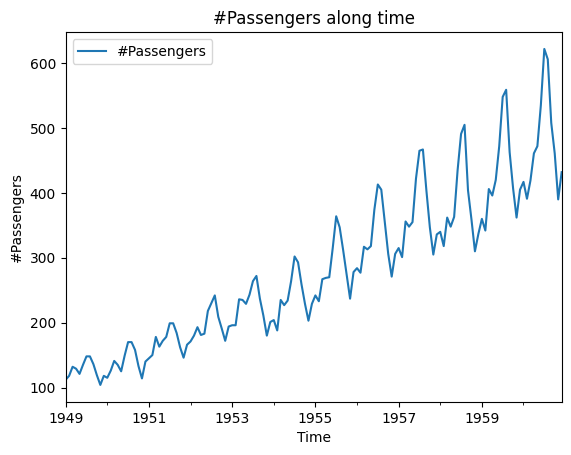

In [197]:
ax = df.plot(title="#Passengers along time", xlabel="Time", ylabel="#Passengers")
plt.show()

### Small snippet on standardization
Before going on details in our analysis, I’d like to make a short explanation about standardization

## Preprocessing

### Standardization
As a first step we have to apply a Standardization of data, because otherwise the activation functions don't work properly.  

Before going on into details in our analysis, I’d like to make a short explanation about standardization

The effect of the standardization is to move the series in order to have the mean on 0, and to press it in order to reach deviation = 1.

In [198]:
from sklearn.preprocessing import StandardScaler

# Applying standardization to the dataset
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=scaler.get_feature_names_out(), index=df.index)

# Visualization of data
print("Let's see the difference before and after standardization of data")
print("\nOriginal data")
display(df.head())

print("\nStandardized data")
display(df_scaled.head())

Let's see the difference before and after standardization of data

Original data


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121



Standardized data


,#Passengers
Month,
1949-01-01,-1.407779
1949-02-01,-1.357590
1949-03-01,-1.240483
1949-04-01,-1.265578
1949-05-01,-1.332496


Just to explain more accurately what it means the application of standardization, I would like to show the difference of the distribution before and after the standardization.

In [199]:
# Definition of a function to plot distribution of data with the avg and std
def plot_distribution(data, column_name, title="Distribution", disable_show=False):
    """
    Plot the distribution of a numerical column from a DataFrame, showing the mean and standard deviation.

    Parameters
    ----------
    data : pandas.DataFrame
        The DataFrame containing the data to plot.
    column_name : str
        The name of the column in `data` to plot.
    title : str, optional
        Title of the plot (default is "Distribution").
    disable_show : bool, optional
        If False (default), the function creates a figure and calls plt.show() 
        automatically, which is convenient for quick visualizations. 
        If True, it does not call plt.show(), allowing you to manage figures and subplots manually.

    Returns
    -------
    None
        The function only plots the histogram and prints the mean and standard deviation.
    """    
    if not(disable_show): plt.figure(figsize=(8, 4))
    sns.histplot(data[column_name], kde=True)
    
    mean = data[column_name].mean()
    std = data[column_name].std()
    
    plt.axvline(mean, color="blue", linestyle="--", label="Mean")
    plt.axvline(mean - std, color="red", linestyle="--", label="Mean ± St")
    plt.axvline(mean + std, color="red", linestyle="--",)
    
    plt.title(title)
    plt.legend()
    if not(disable_show): plt.show()
    
    print(f"{title}\tMean: {mean:.2f}, Std: {std:.2f}")



---- BEFORE STANDARDIZATION -----


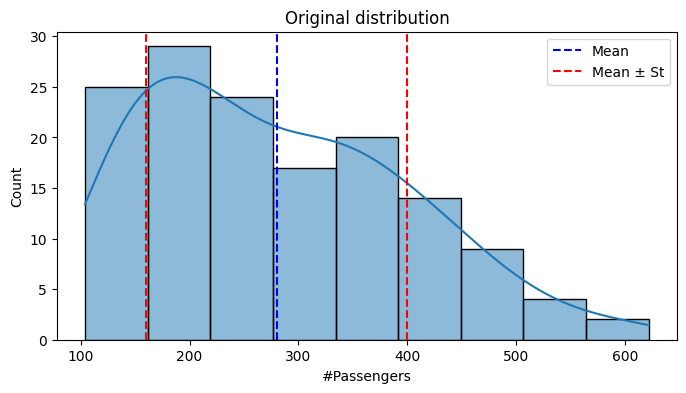

Original distribution	Mean: 280.30, Std: 119.97


---- AFTER STANDARDIZATION -----


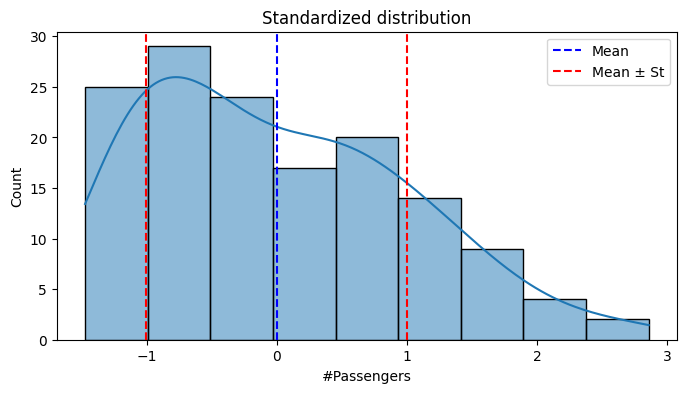

Standardized distribution	Mean: 0.00, Std: 1.00


In [200]:

# Original distribution
print("\n---- BEFORE STANDARDIZATION -----")
plot_distribution(df, "#Passengers", "Original distribution")

# Standardized distribution
print("\n\n---- AFTER STANDARDIZATION -----")
plot_distribution(df_scaled, "#Passengers", "Standardized distribution")

As you can see, the  distribution histogram is the same, but the center (mean) and the scale of the x-axis change.

Standardization moves the series so that the **mean** is 0 and “squeezes/press” the scale so that the **standard deviation** lines lie at -1 and +1.

This helps put different variables on the same scale while preserving their relative distribution.

### Creating sequences
Before defining the model, we need to prepare our data by creating **sliding windows** (or sequences) of fixed length, which the LSTM can process.  
LSTMs require the input data to be organized as sequences — each containing n consecutive time steps — so that the model can learn to predict the next value based on the previous n observations.

In [201]:
# Definition of timestep
window_size= 12
df_scaled[:window_size]

,#Passengers
Month,
1949-01-01,-1.407779
1949-02-01,-1.357590
1949-03-01,-1.240483
1949-04-01,-1.265578
1949-05-01,-1.332496
1949-06-01,-1.215389
1949-07-01,-1.106647
1949-08-01,-1.106647
1949-09-01,-1.207024


In [202]:
def create_sequences(data, window_size, steps=1):
    X, y = [], []

    for i in range(len(data) - window_size - steps + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+steps])
    
    return np.array(X), np.array(y)


In [203]:
X,y = create_sequences(df_scaled, window_size)
X = X.reshape((X.shape[0], X.shape[1]))
y = y.reshape((y.shape[0], y.shape[1]))

df_windows = pd.DataFrame(X, columns=[f"t-{i}" for i in range(window_size, 0,-1)])
df_windows["t"] = y

print("\ndf organized as a sequence:")
df_windows.head()


df organized as a sequence:


,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
0,-1.407779,-1.357590,-1.240483,-1.265578,-1.332496,-1.215389,-1.106647,-1.106647,-1.207024,-1.349225,-1.474697,-1.357590,-1.382685
1,-1.357590,-1.240483,-1.265578,-1.332496,-1.215389,-1.106647,-1.106647,-1.207024,-1.349225,-1.474697,-1.357590,-1.382685,-1.290672
2,-1.240483,-1.265578,-1.332496,-1.215389,-1.106647,-1.106647,-1.207024,-1.349225,-1.474697,-1.357590,-1.382685,-1.290672,-1.165201
3,-1.265578,-1.332496,-1.215389,-1.106647,-1.106647,-1.207024,-1.349225,-1.474697,-1.357590,-1.382685,-1.290672,-1.165201,-1.215389
4,-1.332496,-1.215389,-1.106647,-1.106647,-1.207024,-1.349225,-1.474697,-1.357590,-1.382685,-1.290672,-1.165201,-1.215389,-1.299037


In [204]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X = pd.DataFrame(X, columns=[f"t-{i}" for i in range(window_size, 0,-1)])

#Here we split train and test by using only the last 12 months for the prediction
X_train = X[:-window_size]
X_test= X[-window_size:]

y_train = np.array(y[:-window_size])
y_test = np.array(y[-window_size:])

print("==== Train =====")
display(X_train.head(5), y_train[:5])

print("\n\n==== Test ====")
display(X_test.head(5), y_test[:5])

==== Train =====


,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
0,-1.407779,-1.357590,-1.240483,-1.265578,-1.332496,-1.215389,-1.106647,-1.106647,-1.207024,-1.349225,-1.474697,-1.357590
1,-1.357590,-1.240483,-1.265578,-1.332496,-1.215389,-1.106647,-1.106647,-1.207024,-1.349225,-1.474697,-1.357590,-1.382685
2,-1.240483,-1.265578,-1.332496,-1.215389,-1.106647,-1.106647,-1.207024,-1.349225,-1.474697,-1.357590,-1.382685,-1.290672
3,-1.265578,-1.332496,-1.215389,-1.106647,-1.106647,-1.207024,-1.349225,-1.474697,-1.357590,-1.382685,-1.290672,-1.165201
4,-1.332496,-1.215389,-1.106647,-1.106647,-1.207024,-1.349225,-1.474697,-1.357590,-1.382685,-1.290672,-1.165201,-1.215389


array([[-1.38268454],
       [-1.29067209],
       [-1.16520057],
       [-1.21538918],
       [-1.29903686]])



==== Test ====


,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
120,0.666684,0.516118,1.051463,0.967815,1.168570,1.603538,2.239260,2.331272,1.528255,1.059828,0.683413,1.043098
121,0.516118,1.051463,0.967815,1.168570,1.603538,2.239260,2.331272,1.528255,1.059828,0.683413,1.043098,1.143475
122,1.051463,0.967815,1.168570,1.603538,2.239260,2.331272,1.528255,1.059828,0.683413,1.043098,1.143475,0.925991
123,0.967815,1.168570,1.603538,2.239260,2.331272,1.528255,1.059828,0.683413,1.043098,1.143475,0.925991,1.160205
124,1.168570,1.603538,2.239260,2.331272,1.528255,1.059828,0.683413,1.043098,1.143475,0.925991,1.160205,1.511525


array([[1.14347541],
       [0.92599144],
       [1.16020494],
       [1.5115252 ],
       [1.60353765]])

## Defining the structure of the Network
Since LSTM is a specific type of RNN, I would like to explain how to deal with NN in general.

### How to work with a NN


Before defining the structure of a NN I would like to explain how it is built.  

*What is the approach in building a NN?*

A **neural network** can be seen as a container of layers that work together to produce an output. They are like a pipeline, in which every layer has a particular task.

![Pipeline Example](https://media.istockphoto.com/id/921543952/vector/cottage-construction-steps-vector-flat-isometric-icon-set.jpg?s=1024x1024&w=is&k=20&c=T74r79voTJvtHssaCOmduI5Sy9qjI7HXzM5HUxPoJTk= "Pipeline Example")

Just as the house in the image is built **stage by stage**, neural networks are composed through a **sequence of layers**, each adding its part to the final result.

But if neural networks are like a composition of layers, *who are the “building blocks” and how we combine together?*  
Just as in house construction, in neural networks each layer has a defined function and to build a network effectively, we need to know the main components, their purpose, and how to combine them to create something more complex and functional.

Here we describe the fundamental layers, especially those commonly used in LSTM-based networks.

![LSTM Architecture Overview](https://www.researchgate.net/publication/361277140/figure/fig3/AS:11431281172916582@1688696473304/Long-Short-Term-Memory-LSTM-network-sequence-to-sequence-model-sketch.png "LSTM Model Overview")

1) ***LSTM***:  
Think of the LSTM layer as the brain of the network. Its main role is to analyze sequential data and capture temporal patterns, recognizing trends and cycles in time-series data.  
Focusing on a few important parameters:
  - *units*: number of memory cells (the larger, the more information the model can retain)  
  - *return_sequences*: *True* to pass the full sequence to the next layer, *False* to pass only the last output  
  - *input_shape = (timesteps, features)*: specifies the structure of the input data  

2) ***Dense***:  
The Dense layer acts as a **decision-making component**. It takes the features extracted by previous layers, combines them, and transforms them into meaningful outputs. By applying activation functions such as *ReLU*, *tanh*, or *sigmoid*, it introduces non-linearity, allowing the network to model more complex relationships. Dense layers are commonly used **towards the end of neural networks**, after convolutional or recurrent layers, to perform the final processing and produce the desired output.

3) ***Dropout***:  
This layer prevents **overfitting** by randomly selecting a percentage of neurons to drop during training.

4) ***Input (conceptual)***:  
The Input layer defines the **shape and structure** of the data entering the network.  
Parameters:
  - *input_shape = (timesteps, features)*  
> **Practical note:** In Keras, the input shape is usually specified directly inside the first LSTM or Dense layer, so an explicit `Input` layer is optional.

5) ***Output (conceptual)***:  
The Output layer produces the **final prediction**.  
Parameters:
  - *units*: usually 1 for a regression task  
  - *activation*:  

    - `linear` for regression  
    - `sigmoid` for binary classification  
    - `softmax` for multi-class classification  
> **Practical note:** In practice, a simple `Dense(1)` is often used directly as the output layer.

### Building Our LSTM Network

After describing the main building blocks of a neural network (LSTM, Dense, Dropout, Input/Output), we can now move on to the practical part: **constructing our model**.

We will proceed with a first model, using only input, LSTM and output layer, in order to approach with LSTM and to establish a **baseline**.  
For simplicity, we fix some parameters (number of LSTM units, batch size, number of epochs, etc.) without optimizing them immediately; tuning will be done later.

The goal of this part is to have a clear reference and see how much we can improve the model by adding complexity or optimizing hyperparameters.

In [205]:
# Defining the shape for the LSTM input
timesteps = X_train.shape[1]  # sequence length
features = X_train.shape[2] if X_train.ndim == 3 else 1  # features number, 1 if univariate

batch= 16
# "fixed" because in this df we will store results of the models with fixed params
df_results_fixed = pd.DataFrame(columns=[
    "model_name",
    "epochs",
    "best_loss",
    "RMSE",
    # "mae",
    "elapsed_sec"
])

#### First Model

In [206]:
## BASELINE MODEL (LSTM + Dense(1))

with tf.device('/CPU:0'):
    
    callback= EarlyStopping(
        monitor='loss',
        patience=5,
        restore_best_weights=True)

    model_simple = Sequential()
    model_simple.add(Input(shape=(timesteps, features)))
    model_simple.add(LSTM(64))
    model_simple.add(Dense(1))
    model_simple.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

##### Compilation of the network
The method *compile* is used by the developer to "explain" how the model must learn, by specifing the method, what loss function to optimize and how.
As parameters it has:
- *optimizer* : how to update wheights (Adam, SGD,...)
- *loss* : loss function to optimize (mse, mae,...)

In [207]:
with tf.device('/CPU:0'):

    start = time.time() #this is to calculate training time

    model_simple.compile(optimizer='adam', loss='mae', metrics=[RootMeanSquaredError()])
    history = model_simple.fit(X_train, y_train, epochs=100, batch_size=batch, callbacks=[callback], verbose=True)
    print("Epochs:", len(history.history['loss']))
    
    elapsed = time.time() - start

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.6668 - root_mean_squared_error: 0.8079
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4451 - root_mean_squared_error: 0.5826
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3224 - root_mean_squared_error: 0.4546
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2942 - root_mean_squared_error: 0.4027
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2955 - root_mean_squared_error: 0.3896
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2855 - root_mean_squared_error: 0.3761
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2773 - root_mean_squared_error: 0.3768
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2738 - root_mean_squared_error: 0.3756
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2653 - root_mean_squared_error: 0.3645
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2632 - root_mean_squared_error: 0.3612
Epoch 11/

Here we will try to predict the value for the test set and to plot them to see differences with true values. This can show us the quality of the prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


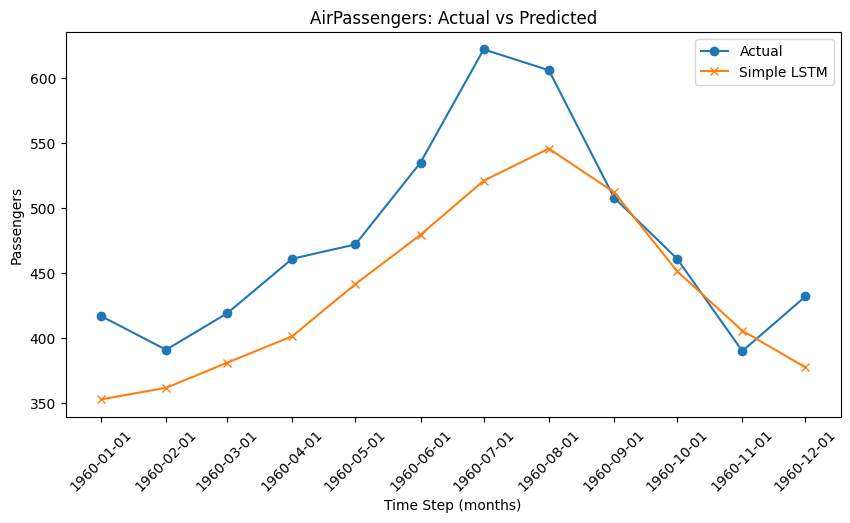

RMSE: 50.94643589987835


In [208]:
# # For the simple model

from sklearn.metrics import root_mean_squared_error, mean_absolute_error

# Make predictions
y_pred_simple = scaler.inverse_transform(model_simple.predict(X_test))
y_test_inv_trasf = scaler.inverse_transform(y_test)
rmse = root_mean_squared_error(y_test_inv_trasf, y_pred_simple)
# mae= mean_absolute_error(y_test,)


# Append to df inline
df_results_fixed.loc[len(df_results_fixed)] = [
    "Baseline LSTM",                            #Name of model 
    np.argmin(history.history['loss']) + 1,     #Epochs
    min(history.history['loss']),               #min loss
    rmse,
    elapsed]


plt.figure(figsize=(10,5))

# Actual values
plt.plot(df[-window_size:].index, y_test_inv_trasf, label='Actual', marker='o')

# Simple model predictions
plt.plot(df[-window_size:].index, y_pred_simple, label='Simple LSTM', marker='x')

plt.title('AirPassengers: Actual vs Predicted')
plt.xlabel('Time Step (months)')
plt.ylabel('Passengers')
plt.xticks(df.index[-12:], rotation=45)
plt.legend()
plt.show()

print(f"RMSE: {rmse}")

As you can see by this image, the the result are similar to the true ones...so it is a good result and we could be satisfied.  
But let see what happen if we add additional layer to see if we can reach few improvements.

#### Advanced Models

Starting from the baseline, we gradually add:

1. a second LSTM layer  
2. an intermediate Dense layer  
3. a Dropout layer  

The goal is to observe **how prediction quality changes** as model complexity increases.

##### 2 LSTM layer
An additional LSTM layer helps capture more complex patterns or combinations of trends and seasonality in the data, and improves the quality of predictions

In [209]:
# ==== MODEL 2: Double LSTM ====

with tf.device('/CPU:0'):
    
    callback= EarlyStopping(
        monitor='loss',
        patience=5,
        restore_best_weights=True)
    
    model_lstm2 = Sequential()
    model_lstm2.add(Input(shape=(timesteps, features)))
    model_lstm2.add(LSTM(64, return_sequences=True))
    model_lstm2.add(LSTM(64))
    ## These layers will be added on the next steps
    # model_lstm2.add(Dense(128, activation='relu'))
    # model_lstm2.add(Dropout(0.2))
    
    model_lstm2.add(Dense(1))
    model_lstm2.summary()

    start = time.time()
    
    model_lstm2.compile(optimizer='adam', loss='mse')
    history = model_lstm2.fit(X_train, y_train, epochs=200, batch_size=batch, callbacks=[callback])
    
    elapsed = time.time() - start

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 12, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.4757
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1904
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1657
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1676
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1510
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1451
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1445
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1371
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1381
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1279
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1188
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1168
Epoch 13/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1073
Epoch 14/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0948
Epoch 15/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0885
Epoch 16/200
8/8 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


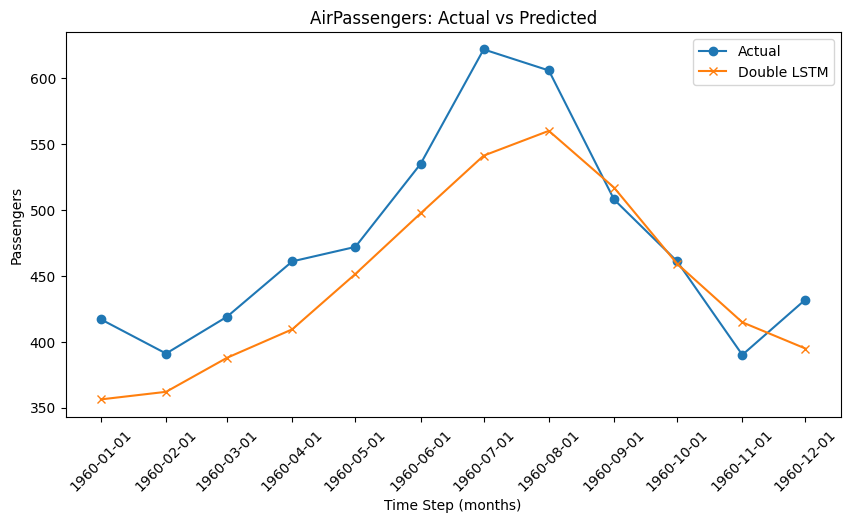

RMSE: 41.538598403228846


In [210]:
# Make predictions
y_pred_lstm2 = scaler.inverse_transform(model_lstm2.predict(X_test))
rmse = root_mean_squared_error(y_test_inv_trasf, y_pred_lstm2)

# Append to df inline
df_results_fixed.loc[len(df_results_fixed)] = [
    "2LSTM",                            #Name of model 
    np.argmin(history.history['loss']) + 1,     #Epochs
    min(history.history['loss']),               #min loss
    rmse,
    elapsed]


plt.figure(figsize=(10,5))

# Actual values
plt.plot(df[-window_size:].index, y_test_inv_trasf, label='Actual', marker='o')

# Simple model predictions
plt.plot(df[-window_size:].index, y_pred_lstm2, label='Double LSTM', marker='x')

plt.title('AirPassengers: Actual vs Predicted')
plt.xlabel('Time Step (months)')
plt.ylabel('Passengers')
plt.xticks(df.index[-12:], rotation=45)
plt.legend()
plt.show()

print(f"RMSE: {rmse}")

##### Addition of a dense layer
This layer transforms the temporal patterns extracted by the LSTMs into meaningful outputs, allowing the model to learn more complex combinations of features and improve predictive performance.

In [211]:
# ==== MODEL 3: LSTM + Dense ====


with tf.device('/CPU:0'):
    
    callback= EarlyStopping(
        monitor='loss',
        patience=5,
        restore_best_weights=True)
    
    model_dense = Sequential()
    model_dense.add(Input(shape=(timesteps, features)))
    model_dense.add(LSTM(64, return_sequences=True))
    model_dense.add(LSTM(64))
    model_dense.add(Dense(128, activation='relu'))
    # model_dense.add(Dropout(0.2))
    model_dense.add(Dense(1))
    model_dense.summary()

    start = time.time()
    
    model_dense.compile(optimizer='adam', loss='mse')
    history = model_dense.fit(X_train, y_train, epochs=200, batch_size=batch, callbacks=[callback])
    
    elapsed = time.time() - start

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 12, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.5944
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2286
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1803
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1618
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1543
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1439
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1490
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1481
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1421
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1372
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1333
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1327
Epoch 13/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1270
Epoch 14/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1247
Epoch 15/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1152
Epoch 16/200
8/8 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


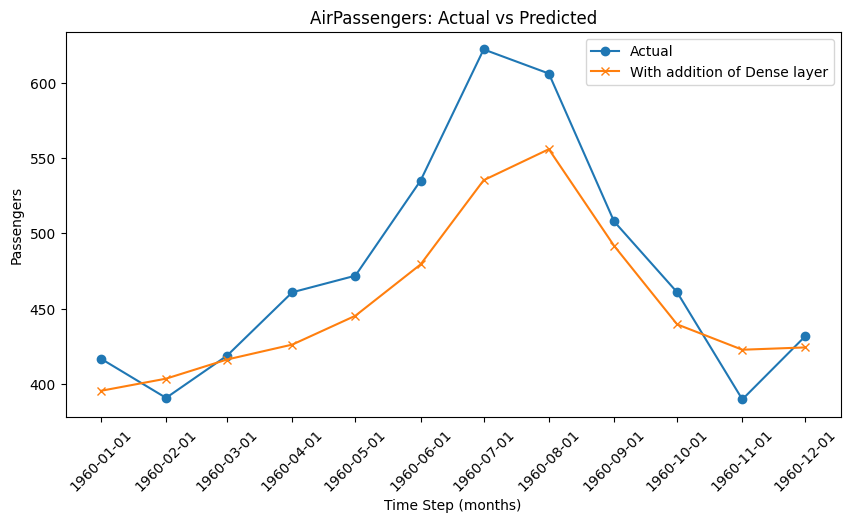

RMSE: 38.19183459163359


In [212]:
# Make predictions
y_pred_dense = scaler.inverse_transform(model_dense.predict(X_test))
rmse = root_mean_squared_error(y_test_inv_trasf, y_pred_dense)

# Append to df inline
df_results_fixed.loc[len(df_results_fixed)] = [
    "Dense",                            #Name of model 
    np.argmin(history.history['loss']) + 1,     #Epochs
    min(history.history['loss']),               #min loss
    rmse,
    elapsed]

plt.figure(figsize=(10,5))

# Actual values
plt.plot(df[-window_size:].index, y_test_inv_trasf, label='Actual', marker='o')

# Simple model predictions
plt.plot(df[-window_size:].index, y_pred_dense, label='With addition of Dense layer', marker='x')

plt.title('AirPassengers: Actual vs Predicted')
plt.xlabel('Time Step (months)')
plt.ylabel('Passengers')
plt.xticks(df.index[-12:], rotation=45)
plt.legend()
plt.show()

print(f"RMSE: {rmse}")

##### Final model: with Dropout layer
The last modification we apply is the addition of a Dropout layer, which helps prevent overfitting by randomly dropping a fraction of neurons during training.

In [213]:
# ==== MODEL 4: LSTM + Dense + Dropout ====


with tf.device('/CPU:0'):
    
    callback= EarlyStopping(
        monitor='loss',
        patience=5,
        restore_best_weights=True)
    
    model_dropout = Sequential()
    model_dropout.add(Input(shape=(timesteps, features)))
    model_dropout.add(LSTM(64, return_sequences=True))
    model_dropout.add(LSTM(64))
    model_dropout.add(Dense(128, activation='relu'))
    model_dropout.add(Dropout(0.05))
    model_dropout.add(Dense(1))
    model_dropout.summary()

    start = time.time()
    
    model_dropout.compile(optimizer='adam', loss='mse')
    history = model_dropout.fit(X_train, y_train, epochs=200, batch_size=batch, callbacks=[callback])
    
    elapsed = time.time() - start

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 12, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.5541
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2236
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1758
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1558
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1445
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1427
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1432
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1370
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1363
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1301
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1227
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1336
Epoch 13/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1418
Epoch 14/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1156
Epoch 15/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1131
Epoch 16/200
8/8 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


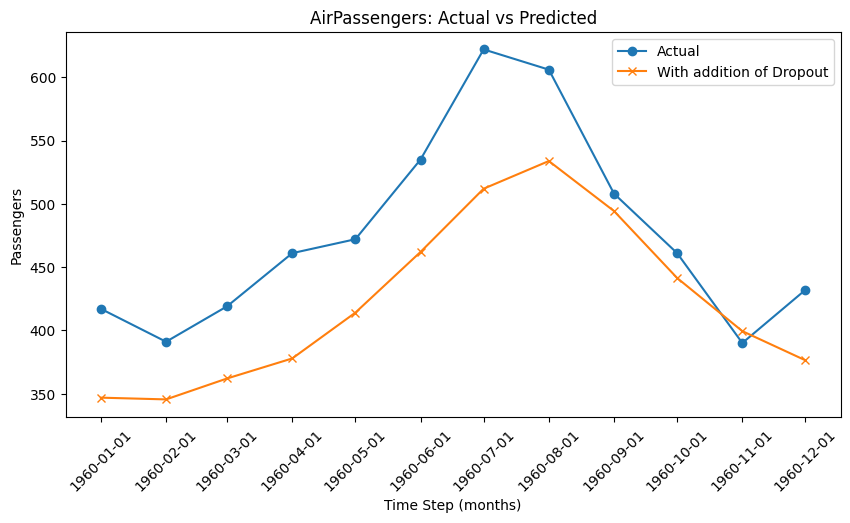

RMSE: 62.5584021394403


In [214]:
# Make predictions
y_pred_dropout = scaler.inverse_transform(model_dropout.predict(X_test))
rmse = root_mean_squared_error(y_test_inv_trasf, y_pred_dropout)

# Append to df inline
df_results_fixed.loc[len(df_results_fixed)] = [
    "Dropout",                            #Name of model 
    np.argmin(history.history['loss']) + 1,     #Epochs
    min(history.history['loss']),               #min loss
    rmse,
    elapsed]

plt.figure(figsize=(10,5))

# Actual values
plt.plot(df[-window_size:].index, y_test_inv_trasf, label='Actual', marker='o')

# Simple model predictions
plt.plot(df[-window_size:].index, y_pred_dropout, label='With addition of Dropout', marker='x')

plt.title('AirPassengers: Actual vs Predicted')
plt.xlabel('Time Step (months)')
plt.ylabel('Passengers')
plt.xticks(df.index[-12:], rotation=45)
plt.legend()
plt.show()

print(f"RMSE: {rmse}")

Results of different trained models


,model_name,epochs,best_loss,RMSE,elapsed_sec
0,Baseline LSTM,43,0.144899,50.946436,10.581140
1,2LSTM,31,0.040459,41.538598,9.886896
2,Dense,49,0.024007,38.191835,12.507201
3,Dropout,28,0.044786,62.558402,17.906068


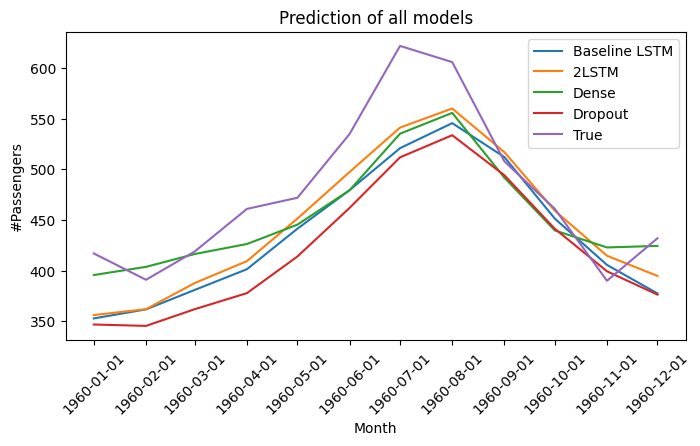

Results sorted by RMSE


,model_name,epochs,best_loss,RMSE,elapsed_sec
2,Dense,49,0.024007,38.191835,12.507201
1,2LSTM,31,0.040459,41.538598,9.886896
0,Baseline LSTM,43,0.144899,50.946436,10.581140
3,Dropout,28,0.044786,62.558402,17.906068


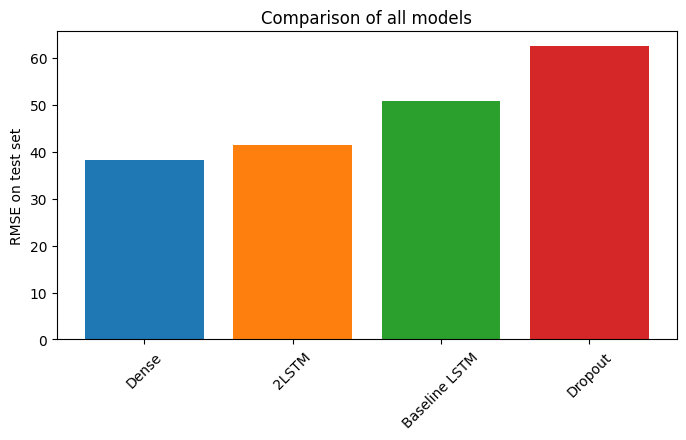

In [215]:
print("Results of different trained models")
display(df_results_fixed)

plt.figure(figsize=(8,4))

for i, y_pred in enumerate([y_pred_simple, y_pred_lstm2, y_pred_dense, y_pred_dropout]):
    plt.plot(df.index[-12:], y_pred, label= df_results_fixed.loc[i]["model_name"])

plt.plot(df.index[-12:], y_test_inv_trasf, label= "True")
plt.xticks(df.index[-12:], rotation=45)
plt.xlabel("Month")
plt.ylabel("#Passengers")
plt.title("Prediction of all models")
plt.legend()
plt.show()

df_results_fixed.sort_values(by=["RMSE"], inplace=True)
print("Results sorted by RMSE")
display(df_results_fixed)

plt.figure(figsize=(8,4))
plt.bar(df_results_fixed["model_name"], df_results_fixed["RMSE"], color= sns.color_palette())
plt.xticks(rotation=45)
plt.ylabel("RMSE on test set")
plt.title("Comparison of all models")
plt.show()

#### Optimization and tuning
After testing different layer compositions with fixed parameters for simplicity (for example batch size or number of units), we now explore various options for each hyperparameter. By training multiple models across different configurations, we aim to identify the combination that provides the best performance.

##### Semplified tuning version
As we have done previously, we will start from a soft version of tuning, by using the `Baseline model` and testing different configuration of number of unit and batch size or other paramters.  
The we will proceed with the last and final training tha will conclude the notebook, providing the **best model** among all possible configuration, but now as to semplify the content for beginner that have never seen this concept, we will se a semplified version of tuning, with a layer model.

In [216]:
# ---------- Experimental Config ----------
batch_sizes = [4, 8, 16]
units_list = [32, 64, 128]         # LSTM units
learning_rates = [0.0005, 0.001, 0.005]  # Adam learning rate
# learning_rates = [0.001]  
repeats = 2
epochs = 200
patience = 5
validation_split = 0.2

timesteps = X_train.shape[1]
features = 1

Experimental Configuration Explained

- **Batch size**: Number of input samples processed before the network updates its weights. Smaller batch sizes can lead to noisier updates but may help generalization; larger batch sizes are more stable but require more memory.
- **Units**: Number of LSTM neurons; more units allow capturing more complex temporal patterns.
- **Learning rate**: Step size used by the optimizer (Adam) to update weights; too high → unstable, too low → slow training.
- **Repeats**: Number of times each configuration (e.g., batch size) is trained to account for randomness in weight initialization and stochastic optimization.
- **Epochs**: Total number of times the model sees the entire training dataset during training.
- **Patience**: Used by the `EarlyStopping` callback. It defines how many epochs with no improvement in the monitored metric (`val_loss`) are allowed before stopping training.
- **Validation split**: Fraction of the training data reserved for validation. This set is not used for training and helps monitor the model's performance on unseen data during training.
- **Timesteps**: Number of time steps (sequence length) used as input for the LSTM. Defines how many past observations the model looks at to make a prediction.
- **Features**: Number of variables/features in each time step. For a univariate time series, this is 1; for multivariate, it equals the number of features in the dataset.


In [217]:
import random
from keras.optimizers import Adam


# ---------- Helper Functions ----------
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)


# def build_model(units=64, lr=0.001):      I wanted to disable defaults value to force the user to set his units and lr
def build_model(units=64, lr=0.001):
    model = Sequential([
        Input(shape=(timesteps, features)),
        LSTM(units),
        Dense(1)
    ])
    #Here we can select the optimizer and seting learning rate
    optimizer = Adam(learning_rate=lr) 
    model.compile(optimizer=optimizer, loss='mse')
    return model

def train_model(batch_size, units, lr):
    with tf.device('/CPU:0'):

        # Reset Keras state to release memory from previous models and avoid resource buildup.
        tf.keras.backend.clear_session()        
        model = build_model(units, lr)

        callback = EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            # min_delta=1e-4,
            verbose=0
        )
    
        start_time = time.time()
        history = model.fit(
            X_train, y_train,
            validation_split=validation_split,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[callback],
            verbose=0
        )
        elapsed = time.time() - start_time

        return model, history, elapsed

In this section we are defining some function to semplify the code of the optimization. As you can see the aim of the function is to build and train a model, by giving it the paramters.
It returns the model trained, the history object and the time spent during training. 

In [218]:
# ---------- Experiment ----------
results_baseline = []

for bs in batch_sizes:
    for units in units_list:
        for lr in learning_rates:
            print(f"\n=== Testing bs={bs}, units={units}, lr={lr} ===")
            batch_results = []
            for run in range(repeats):
                seed = 1000 + run
                set_seeds(seed)

                model, history, elapsed = train_model(bs, units, lr)

                best_val_loss = min(history.history['val_loss'])
                best_epoch = int(np.argmin(history.history['val_loss']) + 1)
                final_train_loss = history.history['loss'][-1]

                batch_results.append({
                    'batch_size': bs,
                    'units': units,
                    'learning_rate': lr,
                    'run': run,
                    'seed': seed,
                    'best_val_loss': float(best_val_loss),
                    'best_epoch': best_epoch,
                    'final_train_loss': float(final_train_loss),
                    'elapsed_sec': elapsed
                })

                print(f" run {run+1}/{repeats} — best_val_loss={best_val_loss:.4f} @epoch {best_epoch} time {elapsed:.1f}s")
            
            results_baseline.extend(batch_results)


=== Testing bs=4, units=32, lr=0.0005 ===
 run 1/2 — best_val_loss=0.3057 @epoch 25 time 12.4s
 run 2/2 — best_val_loss=0.1023 @epoch 118 time 42.2s

=== Testing bs=4, units=32, lr=0.001 ===
 run 1/2 — best_val_loss=0.3277 @epoch 11 time 5.1s
 run 2/2 — best_val_loss=0.1200 @epoch 59 time 13.6s

=== Testing bs=4, units=32, lr=0.005 ===
 run 1/2 — best_val_loss=0.0642 @epoch 17 time 7.5s
 run 2/2 — best_val_loss=0.0751 @epoch 14 time 6.1s

=== Testing bs=4, units=64, lr=0.0005 ===
 run 1/2 — best_val_loss=0.2653 @epoch 14 time 8.5s
 run 2/2 — best_val_loss=0.1014 @epoch 80 time 23.0s

=== Testing bs=4, units=64, lr=0.001 ===
 run 1/2 — best_val_loss=0.3095 @epoch 7 time 4.1s
 run 2/2 — best_val_loss=0.1011 @epoch 43 time 14.3s

=== Testing bs=4, units=64, lr=0.005 ===
 run 1/2 — best_val_loss=0.0619 @epoch 37 time 12.2s
 run 2/2 — best_val_loss=0.0758 @epoch 9 time 5.4s

=== Testing bs=4, units=128, lr=0.0005 ===
 run 1/2 — best_val_loss=0.2758 @epoch 9 time 6.8s
 run 2/2 — best_val_lo

In [219]:
df_results_baseline_opt = pd.DataFrame(results_baseline)
df_results_baseline_opt

,batch_size,units,learning_rate,run,seed,best_val_loss,best_epoch,final_train_loss,elapsed_sec
0,4,32,0.0005,0,1000,0.305750,25,0.050529,12.401982
1,4,32,0.0005,1,1001,0.102252,118,0.014996,42.169631
2,4,32,0.0010,0,1000,0.327739,11,0.060275,5.137066
3,4,32,0.0010,1,1001,0.120005,59,0.016808,13.621873
4,4,32,0.0050,0,1000,0.064241,17,0.018215,7.495095
5,4,32,0.0050,1,1001,0.075081,14,0.017022,6.144335
6,4,64,0.0005,0,1000,0.265297,14,0.043257,8.494477
7,4,64,0.0005,1,1001,0.101427,80,0.017091,23.007920
8,4,64,0.0010,0,1000,0.309513,7,0.053313,4.050533
9,4,64,0.0010,1,1001,0.101059,43,0.016436,14.321472


Saving the results in file system


In [220]:
# Saving results with pickle
# with open("results_baseline_backup.pkl", "wb") as f:
#     pickle.dump(results_baseline, f)

# Salvataggio del DataFrame in CSV
df_results_baseline_opt.to_csv("df_results_baseline_opt.csv", index=True)

In [ ]:
# df_results_baseline_opt = pd.read_csv("df_results_baseline_opt.csv", index_col=0)

Showing results of training phase and some visualization plot.

In [221]:
# Here we aggregate on each configuration
agg_results = df_results_baseline_opt.groupby(['batch_size', 'units', 'learning_rate']).agg(
    mean_val_loss=('best_val_loss', 'mean'),
).reset_index()

# Showing the first 10 rows, to see what are the best 10 configuration for the model.
agg_results_sorted = agg_results.sort_values(by=['mean_val_loss'], ascending=[True,])
print("Top configurations based on mean validation loss (lower is better):")
display(agg_results_sorted.head(10))

Top configurations based on mean validation loss (lower is better):


,batch_size,units,learning_rate,mean_val_loss
17,8,128,0.005,0.060883
5,4,64,0.005,0.068861
2,4,32,0.005,0.069661
14,8,64,0.005,0.075923
8,4,128,0.005,0.077426
11,8,32,0.005,0.085322
20,16,32,0.005,0.085340
26,16,128,0.005,0.085805
23,16,64,0.005,0.089122
16,8,128,0.001,0.098791


Best parameters for Baseline model:

batch_size         8.000000
units            128.000000
learning_rate      0.005000
mean_val_loss      0.060883
Name: 17, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


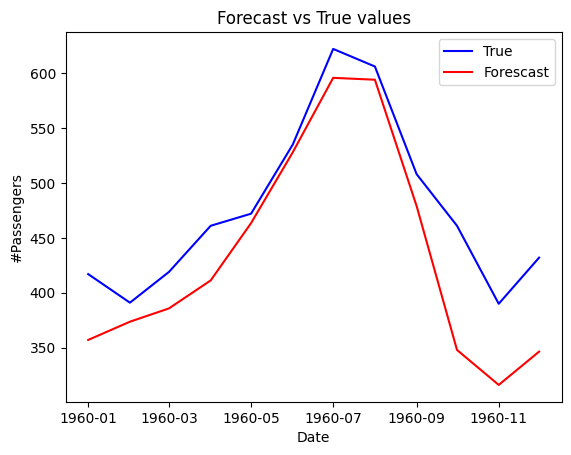

RMSE: 53.87289702890552


In [222]:
# Selecting the best hyperparameters and trying to see what are the results of forecast.
best_param = agg_results_sorted.iloc[0]
print(f"Best parameters for Baseline model:\n\n{best_param}")

batch_size = round(best_param['batch_size'])
n_units = round(best_param['units'])
lr = best_param['learning_rate']

best_model_baseline, history, elapsed =  train_model(batch_size, n_units, lr)

y_pred= scaler.inverse_transform(best_model_baseline.predict(X_test))
# print(y_pred)

plt.plot(df.index[-timesteps:], df['#Passengers'][-timesteps:], label= "True", c= "b")
plt.plot(df.index[-timesteps:], y_pred, label= "Forescast", c="r")
plt.xlabel("Date")
plt.ylabel("#Passengers")
plt.title("Forecast vs True values")
plt.legend()

plt.show()
print("RMSE:", root_mean_squared_error(y_test_inv_trasf, y_pred))

This is the best configuration for the simplest model with only one layer

##### Baseline optimized results

In [223]:
df_agg_batch_size = agg_results_sorted.sort_values(by=['mean_val_loss']).groupby('batch_size').first()
df_agg_batch_size

,units,learning_rate,mean_val_loss
batch_size,,,
4,64,0.005,0.068861
8,128,0.005,0.060883
16,32,0.005,0.085340


Here we are interested to compare the best configuration for each batch size sorting by *mean_val_loss* and to see which batch size could be the best

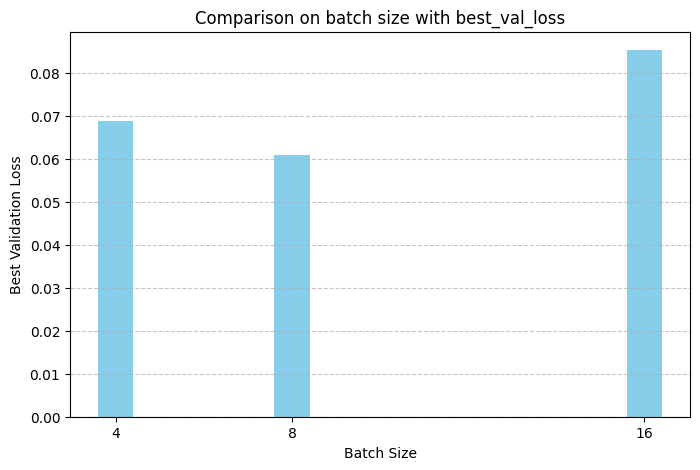

The best batch size for Baseline model is 8


In [224]:
plt.figure(figsize=(8,5))
plt.bar(df_agg_batch_size.index, df_agg_batch_size['mean_val_loss'], color='skyblue')
plt.xlabel('Batch Size')
plt.ylabel('Best Validation Loss')
plt.title('Comparison on batch size with best_val_loss')
plt.xticks(df_agg_batch_size.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

print(f"The best batch size for Baseline model is {df_agg_batch_size.sort_values(by='mean_val_loss').iloc[0].name}")

##### Final (Advanced) tuning

Here we define the functions for the different models build.

In [225]:
def baseline_lstm(units, steps=1):
    model = Sequential([
        Input(shape=(timesteps, features)),
        LSTM(units),
        Dense(steps)
    ])
    return model

def stacked_lstm(units, steps=1):
    model = Sequential([
        Input(shape=(timesteps, features)),
        LSTM(units, return_sequences=True),
        LSTM(units),
        Dense(steps)
    ])
    return model

def lstm_dense(units, dense_units, steps=1):
    model = Sequential([
        Input(shape=(timesteps, features)),
        LSTM(units, return_sequences=True),
        LSTM(units),
        Dense(dense_units),
        Dense(steps)
    ])
    return model

def lstm_dropout(units, dense_units, dropout_rate, steps=1):
    model = Sequential([
        Input(shape=(timesteps, features)),
        LSTM(units, return_sequences=True),
        LSTM(units),
        Dense(dense_units),
        Dropout(dropout_rate),
        Dense(steps)
    ])
    return model


In [17]:
timesteps = X_train.shape[1]
features = 1

epochs = 200
patience = 3
validation_split = 0.2

Setting configuration parameters

In [25]:
# ---------- Experimental Config ----------

batch_sizes = [4, 8, 16, 32]
units_list = [32, 64, 128]         # LSTM units
learning_rates =  [0.005, 0.01] 
repeats = 2

dense_units= [64, 128]
dropout_rates = [0.05, 0.1, 0.2]

param_grid = {
    "baseline_lstm": {
        "model_func": [baseline_lstm],
        "units": units_list,                  # no 128: useless for small dataset
        "batch_size": batch_sizes,           # not used 32 because it was the worst
        "learning_rate": learning_rates  
    },

    "stacked_lstm": {
        "model_func": [stacked_lstm],
        "units": units_list,                  # no 128: useless for small dataset
        "batch_size": batch_sizes,           # not used 32 because it was the worst
        "learning_rate": learning_rates
    },

    "lstm_dense": {
        "model_func": [lstm_dense],
        "units": units_list,                  
        "batch_size": batch_sizes,           
        "learning_rate": learning_rates,  
        "dense_units": dense_units        # ONLY IF lstm_dense 

    },

    "lstm_dropout": {
        "model_func": [lstm_dropout],
        "units": units_list,                  
        "batch_size": batch_sizes,           
        "learning_rate": learning_rates,  
        "dense_units": dense_units,        # ONLY IF lstm_dense 
        "dropout_rate": dropout_rates     # ONLY IF lstm_dropout
    }

}


from sklearn.model_selection import ParameterGrid
params=[]
for name, grid in param_grid.items():
    for combo in ParameterGrid(grid):
        # combo['model_name'] = combo['model_func'].__name__
        params.append(combo)        # aggiungi direttamente ogni combinazione

pd.DataFrame(params)

,batch_size,learning_rate,model_func,units,dense_units,dropout_rate
0,4,0.005,<function baseline_lstm at 0x71d10585e2a0>,32,NaN,NaN
1,4,0.005,<function baseline_lstm at 0x71d10585e2a0>,64,NaN,NaN
2,4,0.005,<function baseline_lstm at 0x71d10585e2a0>,128,NaN,NaN
3,4,0.010,<function baseline_lstm at 0x71d10585e2a0>,32,NaN,NaN
4,4,0.010,<function baseline_lstm at 0x71d10585e2a0>,64,NaN,NaN
...,...,...,...,...,...,...
235,32,0.005,<function lstm_dropout at 0x71d105818680>,64,128.0,0.2
236,32,0.005,<function lstm_dropout at 0x71d105818680>,128,128.0,0.2
237,32,0.010,<function lstm_dropout at 0x71d105818680>,32,128.0,0.2
238,32,0.010,<function lstm_dropout at 0x71d105818680>,64,128.0,0.2


ATTENTION: this cell can take a lot of time, if you are not interest, comment it.

In [51]:
results = []
start_time_training = time.time()

for i, param in enumerate(params):
    model_func = param['model_func']

    # Reset Keras state to release memory from previous models and avoid resource buildup.
    tf.keras.backend.clear_session()
    print(f"Round {i+1}: {param}")
    
    set_seeds()

    with tf.device('/CPU:0'):
        if model_func == baseline_lstm or model_func == stacked_lstm:
            model = model_func(param['units'])
        elif model_func == lstm_dense:
            model = model_func(param['units'], param['dense_units'])
        elif model_func == lstm_dropout:
            model = model_func(param['units'], param['dense_units'], param['dropout_rate'])
        
        optimizer = Adam(learning_rate=param['learning_rate'])  # learning rate di default, si può aggiungere se vuoi
        model.compile(optimizer=optimizer, loss='mse')
        
        # callback = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
            ModelCheckpoint(f"checkpoint/best_v{i}.keras", monitor='val_loss', save_best_only=True, verbose=0)
        ]
        
        start_time = time.time()
        history = model.fit(
            X_train, y_train,
            validation_split=validation_split,
            epochs=epochs,
            batch_size=param['batch_size'],
            callbacks=[callbacks],
            verbose=0
        )

        #Saving all info to file system in order to keep it safe
        model.save(f"models/model_v{i}.keras") 
        with open(f"history/history_{i}.pkl", "wb") as f:
            pickle.dump(history.history, f)
    
    best_val_loss = min(history.history['val_loss'])
    best_epoch = int(np.argmin(history.history['val_loss']) + 1)
    final_train_loss = history.history['loss'][-1]
    elapsed = time.time() - start_time
    
    results.append({
        "model_name": model_func.__name__,
        "units": param['units'],
        "batch_size": param['batch_size'],
        "learning_rate": param['learning_rate'],
        "dense_units": param.get('dense_units', None),
        "dropout_rate": param.get('dropout_rate', None),
        'run': run,
        "best_val_loss": best_val_loss,
        'best_epoch': best_epoch,
        'final_train_loss': float(final_train_loss),
        'epochs': len(history.history['loss']),
        "time": elapsed
    })

    # --- Log modello ---
    print(f"--- Modello {i} completato ---")
    print(f"Epoche: {len(history.history['loss'])}, Best epoch: {best_epoch}")
    print(f"Tempo modello: {elapsed/60:.2f} min, Tempo totale training: {time.time()/60:.2f} min")
    print("-"*50)

df_results_final_opt = pd.DataFrame(results)
df_results_final_opt

Round 1: {'batch_size': 4, 'learning_rate': 0.005, 'model_func': <function baseline_lstm at 0x70f2657c5ee0>, 'units': 32}
--- Modello 0 completato ---
Epoche: 21, Best epoch: 11
Tempo modello: 0.07 min, Tempo totale training: 29521141.77 min
--------------------------------------------------
Round 2: {'batch_size': 4, 'learning_rate': 0.005, 'model_func': <function baseline_lstm at 0x70f2657c5ee0>, 'units': 64}
--- Modello 1 completato ---
Epoche: 24, Best epoch: 14
Tempo modello: 0.07 min, Tempo totale training: 29521141.86 min
--------------------------------------------------
Round 3: {'batch_size': 4, 'learning_rate': 0.005, 'model_func': <function baseline_lstm at 0x70f2657c5ee0>, 'units': 128}
--- Modello 2 completato ---
Epoche: 48, Best epoch: 38
Tempo modello: 0.15 min, Tempo totale training: 29521142.02 min
--------------------------------------------------
Round 4: {'batch_size': 4, 'learning_rate': 0.01, 'model_func': <function baseline_lstm at 0x70f2657c5ee0>, 'units': 32}

,model_name,units,batch_size,learning_rate,dense_units,dropout_rate,run,best_val_loss,best_epoch,final_train_loss,epochs,time
0,baseline_lstm,32,4,0.005,NaN,NaN,1,0.063727,11,0.016711,21,4.438943
1,baseline_lstm,64,4,0.005,NaN,NaN,1,0.062497,14,0.017951,24,4.492943
2,baseline_lstm,128,4,0.005,NaN,NaN,1,0.056734,38,0.010838,48,9.101658
3,baseline_lstm,32,4,0.010,NaN,NaN,1,0.053427,16,0.014812,26,4.714178
4,baseline_lstm,64,4,0.010,NaN,NaN,1,0.055731,8,0.021623,18,3.696150
...,...,...,...,...,...,...,...,...,...,...,...,...
235,lstm_dropout,64,32,0.005,128.0,0.2,1,0.085639,31,0.018880,41,6.162117
236,lstm_dropout,128,32,0.005,128.0,0.2,1,0.086358,23,0.019083,33,5.720373
237,lstm_dropout,32,32,0.010,128.0,0.2,1,0.312546,7,0.082838,17,4.568203
238,lstm_dropout,64,32,0.010,128.0,0.2,1,0.085903,31,0.018807,41,7.658230


Here we save the df to make it available if something goes wrong

In [52]:
# Saving results with pickle
with open("results_advanced_backup.pkl", "wb") as f:
    pickle.dump(results_baseline, f)

# Salvataggio del DataFrame in CSV
df_results_final_opt.to_csv("df_results_advanced_opt.csv", index=True)

Here we upload the dataframe

In [4]:
df_results_final_opt = pd.read_csv("df_results_advanced_opt.csv", index_col=0)

In [5]:
print("These are the best model after training:")
df_results_final_opt.sort_values(by=['best_val_loss']).head()

These are the best model after training:


,model_name,units,batch_size,learning_rate,dense_units,dropout_rate,run,best_val_loss,best_epoch,final_train_loss,epochs,time
131,lstm_dropout,128,4,0.01,128.0,0.20,1,0.022170,61,0.006664,71,18.490812
101,lstm_dropout,128,4,0.01,64.0,0.05,1,0.022278,28,0.007260,38,11.251819
59,lstm_dense,128,4,0.01,128.0,NaN,1,0.022497,40,0.004992,50,14.535671
113,lstm_dropout,128,4,0.01,64.0,0.20,1,0.031246,45,0.009235,55,15.328077
35,stacked_lstm,128,8,0.01,NaN,NaN,1,0.032803,38,0.010324,48,9.819271


In [6]:
print("These are the best model for each model type:")
df_best_for_model = df_results_final_opt.sort_values(by=['best_val_loss']).groupby('model_name').head(1)
df_best_for_model

These are the best model for each model type:


,model_name,units,batch_size,learning_rate,dense_units,dropout_rate,run,best_val_loss,best_epoch,final_train_loss,epochs,time
131,lstm_dropout,128,4,0.01,128.0,0.2,1,0.022170,61,0.006664,71,18.490812
59,lstm_dense,128,4,0.01,128.0,NaN,1,0.022497,40,0.004992,50,14.535671
35,stacked_lstm,128,8,0.01,NaN,NaN,1,0.032803,38,0.010324,48,9.819271
5,baseline_lstm,128,4,0.01,NaN,NaN,1,0.039564,31,0.008346,41,9.008326


Extracting the best 5 model configuration and evaluating them over the test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


,rank_position,RMSE
35,model_5,0.179139
101,model_2,0.204853
131,model_1,0.283098
59,model_3,0.320216
113,model_4,0.333535


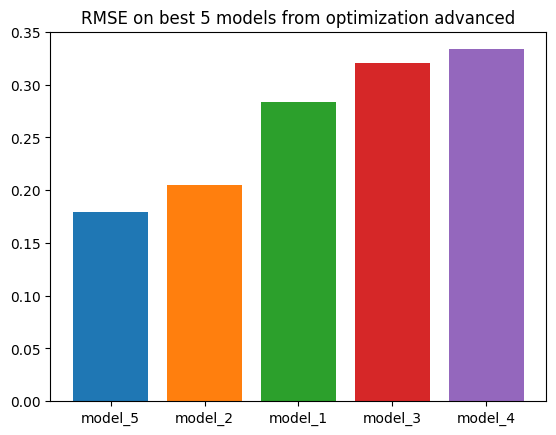

In [59]:
evaluation_results = []

# We take the best model from the dataframe
best_idxs = df_results_final_opt.sort_values(by=['best_val_loss']).index[:5]
best_params = df_results_final_opt.loc[best_idxs]
for i, p in enumerate(best_params.iterrows()): 
    # print(f"Model {i+1}:\n{p[1:]}\n")
    model = tf.keras.models.load_model(f"models/model_v{best_idxs[i]}.keras")
    # model.summary()

    y_pred= model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    evaluation_results.append(rmse)

    
df_evaluation = pd.DataFrame(index=best_idxs)
df_evaluation['rank_position']= [f"model_{i+1}" for i in range(len(evaluation_results))]
df_evaluation['RMSE'] = evaluation_results
df_evaluation.sort_values(by=['RMSE'], inplace=True)

display(df_evaluation)
plt.bar(df_evaluation['rank_position'], df_evaluation['RMSE'], color=sns.color_palette())
plt.title("RMSE on best 5 models from optimization advanced")
plt.show()


From the optimization using all the 4 different sequence of layer and different parameters, we have seen the graduation of the training phase, and now we show the graduation on the RMSE calculated, and the best seems to be 

In [60]:
best_idx = df_evaluation.index[0]
best_param = df_results_final_opt.loc[best_idx]
name= best_param['model_name']

print("Best model is")
df_results_final_opt.loc[[best_idx]]

Best model is


,model_name,units,batch_size,learning_rate,dense_units,dropout_rate,run,best_val_loss,best_epoch,final_train_loss,epochs,time
35,stacked_lstm,128,8,0.01,NaN,NaN,1,0.032803,38,0.010324,48,9.819271


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 594,821 (2.27 MB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 396,548 (1.51 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


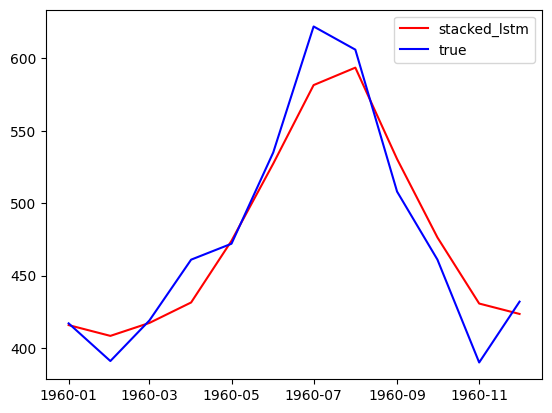

RMSE: 478.43


In [61]:
# Loading the best model optimized from the file system
best_model_advanced = tf.keras.models.load_model(f"models/model_v{best_idx}.keras")
best_model_advanced.summary()

y_pred = scaler.inverse_transform(best_model_advanced.predict(X_test))
rmse = root_mean_squared_error(y_pred, y_test)

plt.plot(df.index[-len(y_pred):], y_pred, label= name, c="r")
plt.plot(df.index[-len(y_pred):], y_test_inv_trasf, label= "true", c="b")

plt.legend()
plt.show()

print(f"RMSE: {rmse:.2f}")

In [62]:
df_best_for_model

,model_name,units,batch_size,learning_rate,dense_units,dropout_rate,run,best_val_loss,best_epoch,final_train_loss,epochs,time
131,lstm_dropout,128,4,0.01,128.0,0.2,1,0.022170,61,0.006664,71,18.490812
59,lstm_dense,128,4,0.01,128.0,NaN,1,0.022497,40,0.004992,50,14.535671
35,stacked_lstm,128,8,0.01,NaN,NaN,1,0.032803,38,0.010324,48,9.819271
5,baseline_lstm,128,4,0.01,NaN,NaN,1,0.039564,31,0.008346,41,9.008326


## Conclusion
We finally reached the end of this notebook and hope you got all the features to understand how to work with LSTM network, but maybe also with NN, because the aim is the same but using other useful layer.

Before the end of this notebook, we show visualization of the results, as the results from the optimization and the prediction of the first 4 fixed param models.

Fixed parameter models


,model_name,epochs,best_loss,RMSE,elapsed_sec
1,2LSTM,46,0.032042,28.658725,8.164624
3,Dropout,37,0.029404,34.094866,12.039572
0,Baseline LSTM,43,0.159570,59.317050,6.838657
2,Dense,28,0.034124,72.908141,7.435471


35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


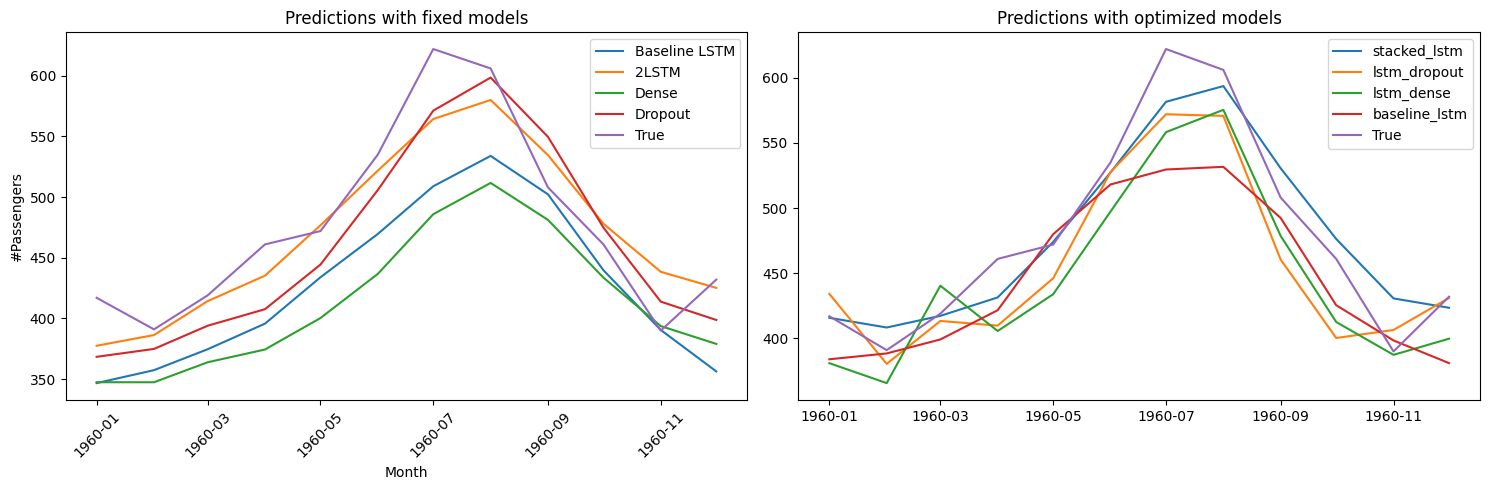

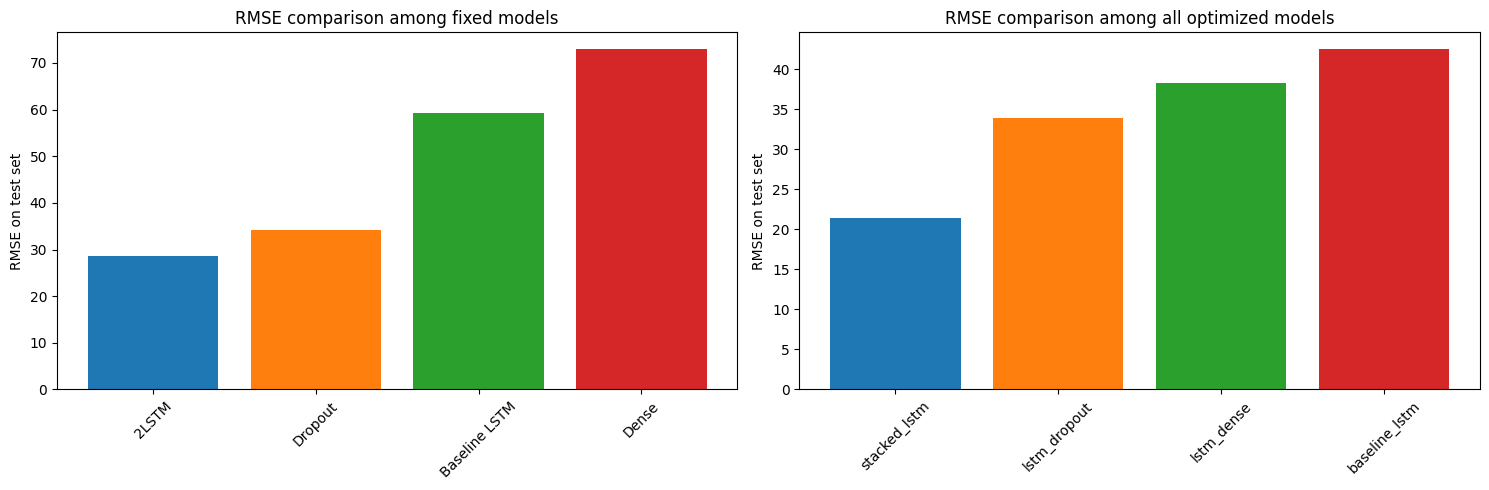

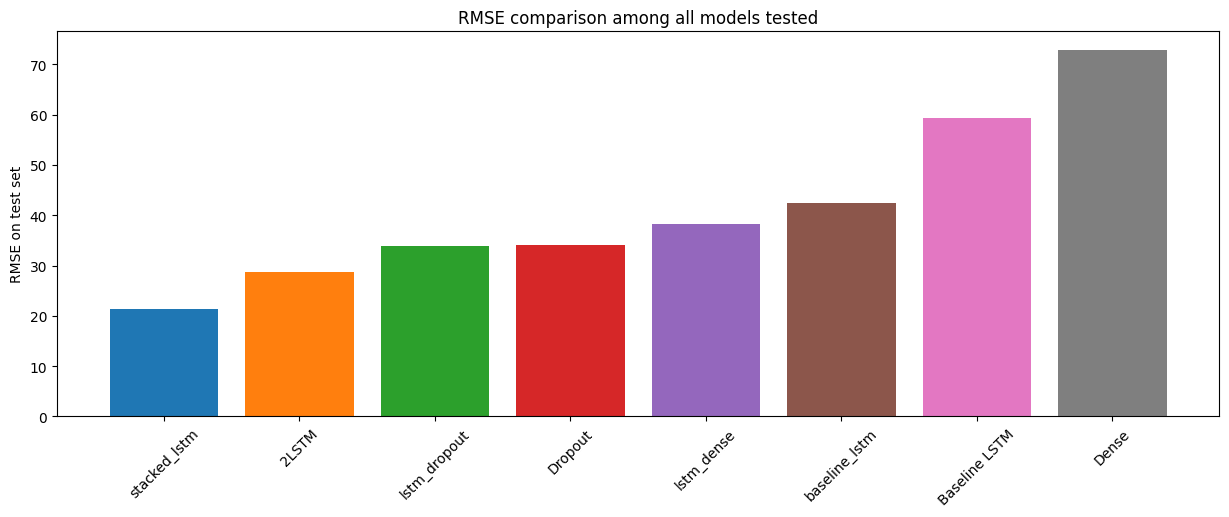

In [75]:
print("Fixed parameter models")
display(df_results_fixed)
# plt.subplots(nrows=1, ncols=2)
fig = plt.figure(figsize=(15,5))
fig.add_subplot(1,2,1)

#Plotting all the prediction by the trained models
for i, y_fixed in enumerate([y_pred_simple, y_pred_lstm2, y_pred_dense, y_pred_dropout]):
    plt.plot(df.index[-12:], y_fixed, label= df_results_fixed.loc[i]["model_name"])

#Plotting true vals
plt.plot(df.index[-12:], y_test_inv_trasf, label= "True")
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("#Passengers")
plt.legend()
plt.title("Predictions with fixed models")

fig.add_subplot(1, 2, 2)    # Bar plot on RMSE

# ====== BEST BASELINE OPTIMIZATION ========
df_rmse_optimized = []

for idx in df_best_for_model.index:
    # print(df_best_for_model.loc[idx])
    print(idx)
    model = tf.keras.models.load_model(f"models/model_v{idx}.keras")
    y_pred = scaler.inverse_transform(model.predict(X_test))
    plt.plot(df.index[-timesteps:], y_pred, label= df_best_for_model.loc[idx, 'model_name'])
    df_rmse_optimized.append(root_mean_squared_error(y_pred, y_test_inv_trasf))

df_best_for_model['RMSE'] = df_rmse_optimized
df_best_for_model.sort_values(by=['RMSE'], inplace=True)

plt.plot(df.index[-12:], y_test_inv_trasf, label= "True")
plt.legend()
plt.title("Predictions with optimized models")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(15,5))
fig.add_subplot(1,2,1)
plt.bar(df_results_fixed["model_name"], df_results_fixed["RMSE"], color= sns.color_palette())
plt.xticks(rotation=45)
plt.ylabel("RMSE on test set")
# plt.bar(['Baseline optimization', 'Advanced optimization'], [rmse_baseline, rmse_advanced], color=sns.color_palette())
plt.title("RMSE comparison among fixed models")

fig.add_subplot(1,2,2)
plt.bar(df_best_for_model["model_name"], df_best_for_model["RMSE"], color= sns.color_palette())
plt.xticks(rotation=45)
plt.ylabel("RMSE on test set")
# plt.bar(['Baseline optimization', 'Advanced optimization'], [rmse_baseline, rmse_advanced], color=sns.color_palette())
plt.title("RMSE comparison among all optimized models")
plt.tight_layout()
plt.show()


# df_results_fixed['model_name'] = df_results_fixed['model_name'] + "_fixed"
# df_best_for_model['model_name'] = df_best_for_model['model_name'] + "_optimized"
df_RMSE = pd.concat([df_results_fixed[['model_name', 'RMSE']], df_best_for_model[['model_name', 'RMSE']]])
df_RMSE.sort_values(by=['RMSE'], inplace=True)

# Plotting an histogram with all RMSEs
plt.figure(figsize=(15,5))
plt.bar(df_RMSE["model_name"], df_RMSE["RMSE"], color= sns.color_palette())
plt.xticks(rotation=45)
plt.ylabel("RMSE on test set")
# plt.bar(['Baseline optimization', 'Advanced optimization'], [rmse_baseline, rmse_advanced], color=sns.color_palette())
plt.title("RMSE comparison among all models tested")
plt.show()

As a result we can see the same pattern with optimized and wiith fixed, I mean, the best seems to be the 2LSTM layer (Stacked LSTM) followed by Dropout, Dense and Baseline at the bottom.  
We can also see that, even the worst of the optimized versions (baseline) is better than the best of the fixed params model, this means that the paramaters chosen for the initial model, in which we tried a fixed configuration wasn't so good, even using the best sequence of layers, to beat a model that which has the simplest sequence of layers, butwith the best hyperparameters.

So the notebook finish here, I leave for you the difference between the true values and the predicted ones by the best model, on the entire dataset, and show some statistic.



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


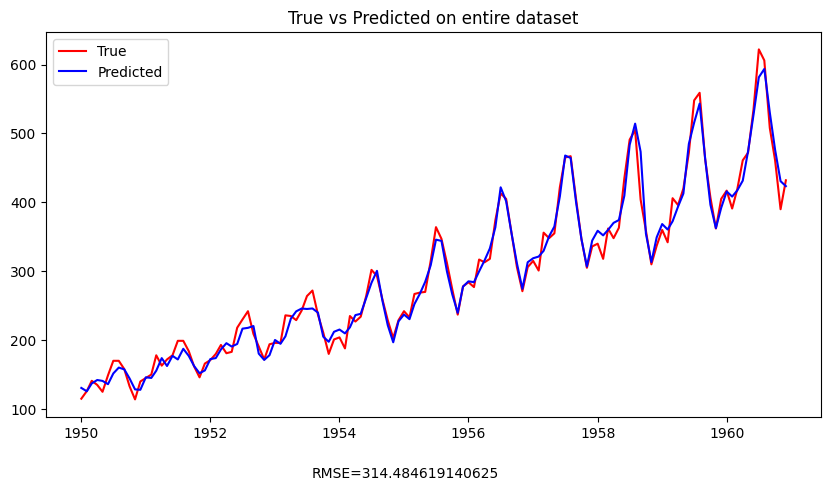

,RMSE,MSE,MAE,MAPE
0,15.057490400741049,226.72801716840883,11.059091047807174,4.14%


In [82]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

y_inv= scaler.inverse_transform(y)

idx = df_RMSE.index[0]
df_results_final_opt.loc[idx]
best_model = tf.keras.models.load_model(f"models/model_v{idx}.keras")
y_pred = scaler.inverse_transform(best_model.predict(X))
rmse_best = root_mean_squared_error(y,y_pred)

plt.figure(figsize=(10,5))
plt.title("True vs Predicted on entire dataset")
plt.text(-6000,-0.1, s=f"RMSE={rmse_best}", horizontalalignment='left')
plt.plot(df.index[window_size:], y_inv, c="r", label="True")
plt.plot(df.index[window_size:], y_pred, c="b", label="Predicted")
plt.legend()
plt.show()


metrics_results = []
metrics_results.append(root_mean_squared_error(y_inv,y_pred))
metrics_results.append(mean_squared_error(y_inv,y_pred))
metrics_results.append(mean_absolute_error(y_inv,y_pred))
metrics_results.append(f"{mean_absolute_percentage_error(y_inv,y_pred):.2%}")
display(pd.DataFrame(np.array(metrics_results).reshape((1,4)), columns=["RMSE", "MSE", "MAE", "MAPE"]))

# Appendix
Here I wanted to make other experiment on the window size and multistep models.
I still have to explain it better, and to add the comment below, but, you can skip this part.

## Final attempt: with different window size.
I wanted to try also different window size

In [29]:
# Settings different window sizes to test
window_sizes = [6,12,24]

results = []
start_time_training = time.time()
timesteps = X_train.shape[1]
features = 1
test_size= 12

for  ws in window_sizes:
    X,y = create_sequences(df_scaled, ws)

    #Here we split train and test by using only the last 12 months for the prediction
    X_train = X[:-test_size]
    X_test= X[-test_size:]

    y_train = np.array(y[:-test_size])
    y_test = np.array(y[-test_size:])
    
    for i, param in enumerate(params):
        model_func = param['model_func']

        # Reset Keras state to release memory from previous models and avoid resource buildup.
        tf.keras.backend.clear_session()
        print(f"Round {i+1}, ws:{ws}: {param}")
        
        set_seeds()

        with tf.device('/CPU:0'):
            if model_func == baseline_lstm or model_func == stacked_lstm:
                model = model_func(param['units'])
            elif model_func == lstm_dense:
                model = model_func(param['units'], param['dense_units'])
            elif model_func == lstm_dropout:
                model = model_func(param['units'], param['dense_units'], param['dropout_rate'])
            
            optimizer = Adam(learning_rate=param['learning_rate'])  # learning rate di default, si può aggiungere se vuoi
            model.compile(optimizer=optimizer, loss='mse')
            
            # callback = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
            callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
                ModelCheckpoint(f"window_{ws}/checkpoint/best_v{i}.keras", monitor='val_loss', save_best_only=True, verbose=0)
            ]
            
            start_time = time.time()
            history = model.fit(
                X_train, y_train,
                validation_split=validation_split,
                epochs=epochs,
                batch_size=param['batch_size'],
                callbacks=[callbacks],
                verbose=0
            )
            os.makedirs(f'window_{ws}/models', exist_ok=True)
            os.makedirs(f'window_{ws}/history', exist_ok=True)
            #Saving all info to file system in order to keep it safe
            model.save(f"window_{ws}/models/model_v{i}.keras") 
            with open(f"window_{ws}/history/history_{i}.pkl", "wb") as f:
                pickle.dump(history.history, f)
        
        best_val_loss = min(history.history['val_loss'])
        best_epoch = int(np.argmin(history.history['val_loss']) + 1)
        final_train_loss = history.history['loss'][-1]
        elapsed = time.time() - start_time
        
        results.append({
            "model_name": model_func.__name__,
            "window_size": ws,
            "units": param['units'],
            "batch_size": param['batch_size'],
            "learning_rate": param['learning_rate'],
            "dense_units": param.get('dense_units', None),
            "dropout_rate": param.get('dropout_rate', None),
            "best_val_loss": best_val_loss,
            'best_epoch': best_epoch,
            'final_train_loss': float(final_train_loss),
            'epochs': len(history.history['loss']),
            "time": elapsed
        })

        # --- Log modello ---
        print(f"--- Modello {i} completato ---")
        print(f"Epoche: {len(history.history['loss'])}, Best epoch: {best_epoch}")
        print(f"Tempo modello: {elapsed/60:.0f}m {elapsed%60:.1f}, Tempo totale training: {(time.time() - start_time_training)/60:.0f} min")
        print("-"*50)

df_results_final_opt = pd.DataFrame(results)
df_results_final_opt

Round 1, ws:6: {'batch_size': 4, 'learning_rate': 0.005, 'model_func': <function baseline_lstm at 0x71d10585e2a0>, 'units': 32}
--- Modello 0 completato ---
Epoche: 23, Best epoch: 13
Tempo modello: 0m 4.4, Tempo totale training: 0 min
--------------------------------------------------
Round 2, ws:6: {'batch_size': 4, 'learning_rate': 0.005, 'model_func': <function baseline_lstm at 0x71d10585e2a0>, 'units': 64}
--- Modello 1 completato ---
Epoche: 21, Best epoch: 11
Tempo modello: 0m 3.7, Tempo totale training: 0 min
--------------------------------------------------
Round 3, ws:6: {'batch_size': 4, 'learning_rate': 0.005, 'model_func': <function baseline_lstm at 0x71d10585e2a0>, 'units': 128}
--- Modello 2 completato ---
Epoche: 19, Best epoch: 9
Tempo modello: 0m 4.0, Tempo totale training: 0 min
--------------------------------------------------
Round 4, ws:6: {'batch_size': 4, 'learning_rate': 0.01, 'model_func': <function baseline_lstm at 0x71d10585e2a0>, 'units': 32}
--- Modello 

,model_name,window_size,units,batch_size,learning_rate,dense_units,dropout_rate,best_val_loss,best_epoch,final_train_loss,epochs,time
0,baseline_lstm,6,32,4,0.005,NaN,NaN,0.104962,13,0.035700,23,4.425117
1,baseline_lstm,6,64,4,0.005,NaN,NaN,0.105844,11,0.035448,21,3.735357
2,baseline_lstm,6,128,4,0.005,NaN,NaN,0.109284,9,0.036377,19,3.977700
3,baseline_lstm,6,32,4,0.010,NaN,NaN,0.087938,20,0.028372,30,5.359739
4,baseline_lstm,6,64,4,0.010,NaN,NaN,0.104065,7,0.035519,17,3.498298
...,...,...,...,...,...,...,...,...,...,...,...,...
715,lstm_dropout,24,64,32,0.005,128.0,0.2,0.074265,48,0.014359,58,7.081123
716,lstm_dropout,24,128,32,0.005,128.0,0.2,0.054720,38,0.013888,48,7.027357
717,lstm_dropout,24,32,32,0.010,128.0,0.2,0.309774,5,0.085210,15,3.006125
718,lstm_dropout,24,64,32,0.010,128.0,0.2,0.104995,28,0.025721,38,5.343374


In [32]:
df_results_final_opt.sort_values(by=['best_val_loss']).head()

,model_name,window_size,units,batch_size,learning_rate,dense_units,dropout_rate,best_val_loss,best_epoch,final_train_loss,epochs,time
371,lstm_dropout,12,128,4,0.01,128.0,0.20,0.022170,61,0.006664,71,15.955760
341,lstm_dropout,12,128,4,0.01,64.0,0.05,0.022278,28,0.007260,38,9.352328
299,lstm_dense,12,128,4,0.01,128.0,NaN,0.022497,40,0.004992,50,12.346320
485,baseline_lstm,24,128,4,0.01,NaN,NaN,0.026901,42,0.004312,52,9.590224
353,lstm_dropout,12,128,4,0.01,64.0,0.20,0.031246,45,0.009235,55,12.846188


In [33]:
import pickle

# Salvataggio della lista results con pickle
# with open("windows_results_backup.pkl", "wb") as f:
#     pickle.dump(results, f)

# Salvataggio del DataFrame in CSV
df_results_final_opt.to_csv("df_windows_results_backup.csv", index=True)

# # Oppure salvataggio del DataFrame con pickle (mantiene tipi e struttura)
# df_results_final_opt.to_pickle("window_results_backup.pkl")

In [13]:
df_results_final_opt = pd.read_csv("df_windows_results_backup.csv", index_col=0)

Best params: model_name          lstm_dropout
window_size                   12
units                        128
batch_size                     4
learning_rate               0.01
dense_units                128.0
dropout_rate                 0.2
best_val_loss            0.02217
best_epoch                    61
final_train_loss        0.006664
epochs                        71
time                    15.95576
Name: 371, dtype: object


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 644,357 (2.46 MB)

 Trainable params: 214,785 (839.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 429,572 (1.64 MB)

Best model: None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


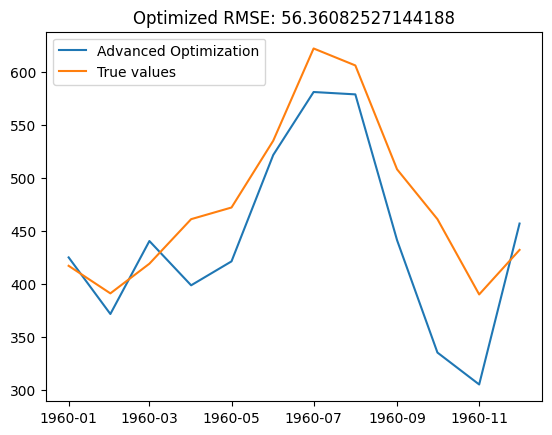

In [ ]:
# ====== BEST FINAL OPTIMIZATION ========

idx_best = df_results_final_opt.sort_values(by=['best_val_loss']).index[0]
best_param = df_results_final_opt.loc[idx_best]
print(f"Best params: {best_param}")
ws= best_param['window_size']

with tf.device('/cpu:0'):
    best_model_advanced = tf.keras.models.load_model(f"window_{ws}/models/model_v{idx_best%240}.keras")
print(f"Best model: {best_model_advanced.summary()}")

y_pred= scaler.inverse_transform(best_model_advanced.predict(X_test))
rmse_advanced = root_mean_squared_error(y_test_inv_trasf, y_pred)

# df["#Passengers"][-len(y_pred):], y_pred

plt.plot(df["#Passengers"][-len(y_pred):].index, y_pred, label= "Advanced Optimization")
plt.plot(df["#Passengers"][-len(y_pred):].index, scaler.inverse_transform(y)[-len(y_pred):], label="True values")
plt.title(f"Optimized RMSE: {rmse_advanced}")
plt.legend()
plt.show()

Best models of all window size is with `ws = 12`
Here we try to make a plot starting from the last 12 values of the train set, and then trying to calculate with a rolling window the next 12, using the predicted data for the prediction of the next one.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[1.4244478]
 [1.1207881]
 [1.1527151]
 [1.116041 ]
 [1.2418747]
 [1.804222 ]
 [2.1312149]
 [2.074037 ]
 [1.5925577]
 [1.0290974]
 [1.1617422]
 [1.5052248]]


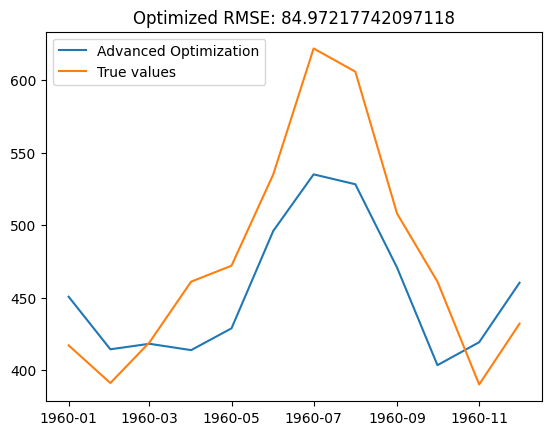

In [72]:
#Here we try to make a plot starting from the last 12 values of the train set, and then trying to calculate with a rolling window the next 12, using the predicted data for the prediction of the next one.
best_ws= best_param['window_size']

rolling_window = df_scaled["#Passengers"][-best_ws:].values.reshape(1, -1)
preds= []

for i in range(best_ws):
    preds.append(best_model_advanced.predict(rolling_window))
    #append the new predicted values to the rolling window
    rolling_window = np.append(rolling_window[:, 1:], preds[i])
    #reshape the rolling window to have the correct shape for the next iteration
    rolling_window = rolling_window.reshape(1, -1)

preds = np.array(preds).reshape((best_ws, 1))
print(preds)

plt.plot(df["#Passengers"][-len(preds):].index, scaler.inverse_transform(preds), label= "Advanced Optimization")
plt.plot(df["#Passengers"][-len(preds):].index, scaler.inverse_transform(y)[-len(preds):], label="True values")
plt.title(f"Optimized RMSE: {rmse_advanced}")
plt.legend()
plt.show()

In [ ]:
# Voglio salvare tutte le variabili come il df, i risultati e altre variabili non pesanti in un checkpoint
# Metterei pacchetti importati, df, dfscaled e scaler, definizioni di funzioni che ho scritto, e i risultati

import pickle
import types

#stampiamo tutti i pacchetti importati
list_var = {}

# ora df, df_scaled, results e scaler
for name, value in globals().items():
    if name.startswith("df") or name.startswith("results") or name.startswith("scaler"):
        list_var[name]= value

# tutto in unico file checkpoint
print("All vars to put in the checkpoint are: ", list_var)

with open('checkpoint.pkl', 'wb') as f:
    pickle.dump(list_var, f)

All vars to put in the checkpoint are:  {'df':             #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
...                 ...
1960-08-01          606
1960-09-01          508
1960-10-01          461
1960-11-01          390
1960-12-01          432

[144 rows x 1 columns], 'scaler': StandardScaler(), 'df_scaled':             #Passengers
Month                  
1949-01-01    -1.407779
1949-02-01    -1.357590
1949-03-01    -1.240483
1949-04-01    -1.265578
1949-05-01    -1.332496
...                 ...
1960-08-01     2.724417
1960-09-01     1.904669
1960-10-01     1.511525
1960-11-01     0.917627
1960-12-01     1.268947

[144 rows x 1 columns], 'df_results_final_opt':        model_name  window_size  units  batch_size  learning_rate  dense_units  \
0    lstm_dropout           12    128           4          0.010        128.0   
1    lstm_dropout           12    128           4   

In [13]:
import pickle
with open('checkpoint.pkl', 'rb') as f:
    checkpoint = pickle.load(f)

print(checkpoint.keys())

#restore all item from checkpoint
for name, value in checkpoint.items():
    globals()[name] = value

dict_keys(['df', 'scaler', 'df_scaled', 'df_results_final_opt', 'df_best_for_model', 'results', 'results_steps', 'df_results_steps', 'df_best_for_step'])


In [20]:
# Here I would like to take the best parameters we have found before and trying also different steps of prediction
steps = [1,2,4,6,12]
results = []
start_time_training = time.time()
test_size= 12
validation_split = 0.2


epochs = 200
patience = 3
validation_split = 0.2

os.makedirs(f'multisteps/models', exist_ok=True)
os.makedirs(f'multisteps/models', exist_ok=True)
os.makedirs(f'multisteps/history', exist_ok=True)

# setting params for the training, choosing only the most effectives
df_results_final_opt.sort_values(by=['best_val_loss']).head(20)

# I would like to extract the best 20 parameters configuration off our results to make a new param grid for a final training session
best_params = []
for i in range(20):
    best_params.append(df_results_final_opt.sort_values(by=['best_val_loss']).iloc[i].to_dict())

for step in steps:
    for i, param in enumerate(best_params):
        #preparing data with sequences
        X,y = create_sequences(df_scaled["#Passengers"], param['window_size'], steps=step)

        #splitting train and test to have last 12 months in the test set
        X_train = X[:-test_size]
        X_test= X[-test_size:]

        y_train = np.array(y[:-test_size])
        y_test = np.array(y[-test_size:])

        # come faccio a recuperare il riferimento alle funzioni dal model_name
        model_func = globals()[param['model_name']]
        timesteps = step
        
        print(f"Model: {param['model_name']}")
        print(f"Time steps: {timesteps}")
        print(f"Features: {features}")
        print(f"Step: {step}")

        with tf.device('/CPU:0'):
            model = None
            if model_func == baseline_lstm or model_func == stacked_lstm:
                model = model_func(param['units'], step)
            elif model_func == lstm_dense:
                model = model_func(param['units'], int(param['dense_units']), step)
            elif model_func == lstm_dropout:
                model = model_func(param['units'], int(param['dense_units']), param['dropout_rate'], step)   


            optimizer = Adam(learning_rate=param['learning_rate'])  # learning rate di default, si può aggiungere se vuoi
            model.compile(optimizer=optimizer, loss='mse')
            
            # callback = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
            callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
                ModelCheckpoint(f"multisteps/checkpoint/best_v{i}.keras", monitor='val_loss', save_best_only=True, verbose=0)
            ]
            
            start_time = time.time()
            history = model.fit(
                X_train, y_train,
                validation_split=validation_split,
                epochs=epochs,
                batch_size=param['batch_size'],
                callbacks=[callbacks],
                verbose=0
            )
            #Saving all info to file system in order to keep it safe
            model.save(f"multisteps/models/model_v{i}.keras") 
            with open(f"multisteps/history/history_{i}.pkl", "wb") as f:
                pickle.dump(history.history, f)
        
        best_val_loss = min(history.history['val_loss'])
        best_epoch = int(np.argmin(history.history['val_loss']) + 1)
        final_train_loss = history.history['loss'][-1]
        elapsed = time.time() - start_time
    
        results.append({
            "model_name": model_func.__name__,
            "window_size": param['window_size'],
            "units": param['units'],
            "batch_size": param['batch_size'],
            "learning_rate": param['learning_rate'],
            "dense_units": param.get('dense_units', None),
            "dropout_rate": param.get('dropout_rate', None),
            "best_val_loss": best_val_loss,
            'best_epoch': best_epoch,
            'final_train_loss': float(final_train_loss),
            'epochs': len(history.history['loss']),
            "time": elapsed
        })

        # --- Log modello ---
        print(f"--- Modello {i} completato ---")
        print(f"Epoche: {len(history.history['loss'])}, Best epoch: {best_epoch}")
        print(f"Tempo modello: {elapsed/60:.0f}m {elapsed%60}s, Tempo totale training: {(time.time() - start_time_training)/60:.0f} min")
        print("-"*50)
    

        

Model: lstm_dropout
Time steps: 1
Features: 1
Step: 1
--- Modello 19 completato ---
Epoche: 33, Best epoch: 23
Tempo modello: 0m 11.2, Tempo totale training: 0 min
--------------------------------------------------
Model: lstm_dropout
Time steps: 1
Features: 1
Step: 1
--- Modello 19 completato ---
Epoche: 23, Best epoch: 13
Tempo modello: 0m 13.3, Tempo totale training: 0 min
--------------------------------------------------
Model: lstm_dense
Time steps: 1
Features: 1
Step: 1
--- Modello 19 completato ---
Epoche: 52, Best epoch: 42
Tempo modello: 0m 13.5, Tempo totale training: 1 min
--------------------------------------------------
Model: baseline_lstm
Time steps: 1
Features: 1
Step: 1
--- Modello 19 completato ---
Epoche: 50, Best epoch: 40
Tempo modello: 0m 12.1, Tempo totale training: 1 min
--------------------------------------------------
Model: lstm_dropout
Time steps: 1
Features: 1
Step: 1
--- Modello 19 completato ---
Epoche: 19, Best epoch: 9
Tempo modello: 0m 6.7, Tempo to

In [41]:
models_per_step = int(len(results) / len(steps))

#per ogni step size andiamo a formare il dataset coi suoi 5 migliori e poi andiamo a creare un dataframe con tutti i risultati
results_steps = []

for i, s in enumerate(steps):
    print(f"Dataset with step {s}")
    df_best_for_step =(df_results_final_opt[i*models_per_step: (i+1)*models_per_step].sort_values(by=['best_val_loss']).head(5))
    df_best_for_step["step"] = s
    results_steps.append(df_best_for_step)

#uniamo i risultati, aggiungendo anche una colonna che mostri gli step
df_results_steps = pd.concat(results_steps)
df_results_steps

Dataset with step 1
Dataset with step 2
Dataset with step 4
Dataset with step 6
Dataset with step 12


,model_name,window_size,units,batch_size,learning_rate,dense_units,dropout_rate,best_val_loss,best_epoch,final_train_loss,epochs,time,step
3,baseline_lstm,24,128,4,0.010,NaN,NaN,0.033640,40,0.003251,50,12.059839,1
18,lstm_dense,24,128,16,0.005,64.0,NaN,0.036427,31,0.010457,41,18.732908,1
11,lstm_dense,24,128,16,0.005,128.0,NaN,0.037362,34,0.012313,44,16.100011,1
12,lstm_dropout,24,128,8,0.005,128.0,0.05,0.039650,34,0.010830,44,16.632359,1
8,stacked_lstm,12,128,4,0.010,NaN,NaN,0.041810,57,0.002477,67,26.478995,1
33,lstm_dropout,24,128,16,0.005,128.0,0.10,0.038407,47,0.011825,57,17.966948,2
25,lstm_dropout,24,128,8,0.005,64.0,0.10,0.042772,33,0.013548,43,18.019343,2
32,lstm_dropout,24,128,8,0.005,128.0,0.05,0.043482,48,0.010082,58,22.172963,2
34,lstm_dense,24,128,8,0.005,128.0,NaN,0.046352,24,0.011048,34,15.227919,2
35,lstm_dropout,24,128,8,0.005,64.0,0.20,0.048460,27,0.015155,37,16.480685,2


In [14]:
for i, param in df_results_steps.iterrows():
    print(f"Model {i}: {param["model_name"]}, step: {param['step']}, window_size: {param['window_size']}")

Model 0: baseline_lstm, step: 1, window_size: 24
Model 1: lstm_dense, step: 1, window_size: 24
Model 2: lstm_dense, step: 1, window_size: 24
Model 3: lstm_dropout, step: 1, window_size: 24
Model 4: stacked_lstm, step: 1, window_size: 12
Model 5: lstm_dropout, step: 2, window_size: 24
Model 6: lstm_dropout, step: 2, window_size: 24
Model 7: lstm_dropout, step: 2, window_size: 24
Model 8: lstm_dense, step: 2, window_size: 24
Model 9: lstm_dropout, step: 2, window_size: 24
Model 10: lstm_dropout, step: 4, window_size: 24
Model 11: lstm_dropout, step: 4, window_size: 24
Model 12: lstm_dropout, step: 4, window_size: 12
Model 13: lstm_dropout, step: 4, window_size: 24
Model 14: lstm_dropout, step: 4, window_size: 12
Model 15: lstm_dense, step: 6, window_size: 12
Model 16: baseline_lstm, step: 6, window_size: 24
Model 17: lstm_dropout, step: 6, window_size: 24
Model 18: lstm_dropout, step: 6, window_size: 24
Model 19: stacked_lstm, step: 6, window_size: 12
Model 20: lstm_dropout, step: 12, wi

In [28]:
def recursive_forecast(model, last_window, steps, forecast_horizon):
    """
    model: modello LSTM allenato
    last_window: ultima finestra reale di train, shape (1, window_size, features)
    steps: quanti valori predice il modello in un colpo (output dimension)
    forecast_horizon: quanti valori vogliamo predire in totale
    """
    preds = []
    rolling_window = last_window.copy()

    for _ in range(0, forecast_horizon, steps):
        pred = model.predict(rolling_window, verbose=0).flatten()
        preds.extend(pred)

        # append predicted values alla finestra
        pred_reshaped = pred.reshape(1, steps, rolling_window.shape[2])
        rolling_window = np.concatenate([rolling_window[:, steps:, :], pred_reshaped], axis=1)

    return np.array(preds[:forecast_horizon])

def sliding_window_forecast(model, X_test):
    """
    Restituisce le predizioni generate dal modello per ogni finestra di X_test
    """
    all_preds = []
    for x in X_test:
        x_input = x.reshape(1, x.shape[0], x.shape[1])  # (1, window_size, features)
        pred = model.predict(x_input, verbose=0)         # (1, step)
        all_preds.append(pred.flatten())
    return all_preds


def plot_fan(df_index, true_values, all_preds):
    """
    Plotta i valori veri e le predizioni fan plot
    df_index: index della serie (ultimi test_size mesi)
    true_values: valori reali corrispondenti
    all_preds: lista di array, ognuno di lunghezza step
    """
    plt.figure(figsize=(10,5))
    plt.plot(df_index, true_values, marker="o", label="True", linewidth=2)

    for i, pred in enumerate(all_preds):
        start_idx = i
        end_idx = start_idx + len(pred)
        if end_idx > len(df_index):
            end_idx = len(df_index)
        plt.plot(df_index[start_idx:end_idx], pred[:end_idx-start_idx],
                 linestyle="--", marker="o", alpha=0.5, label=f"pred@{i+1}")

    plt.legend()
    plt.show()

from sklearn.metrics import mean_squared_error

def compute_fan_rmse(true_values, all_preds):
    """
    true_values: array degli ultimi 12 mesi (scala originale)
    all_preds: lista di array (già inverse_transform)
    """
    rmses = []

    for i, pred in enumerate(all_preds):
        start_idx = i
        end_idx = i + len(pred)

        if end_idx > len(true_values):
            break

        true_segment = true_values[start_idx:end_idx]
        rmse_i = np.sqrt(mean_squared_error(true_segment, pred))
        rmses.append(rmse_i)

    return np.mean(rmses)


In [ ]:
# per ogni entry del dataset, alleniamo il modello con quei parametri, e poi finito il training, per ognuno, stampiamo la prediction per gli ultimi mesi in base al step size
# per esempio se lo step è 1, allora facciamo come prima
results = []
start_time_training = time.time()
test_size= 12
validation_split = 0.2
features= 1


epochs = 200
patience = 3
validation_split = 0.2

for i, param in df_results_steps.iterrows():

    model_func = globals()[param['model_name']]
    step = param['step']

    #preparing data with sequences
    X,y = create_sequences(df_scaled["#Passengers"], param['window_size'], steps=step)
    X = X.reshape((X.shape[0], X.shape[1], features))

    #splitting train and test to have last 12 months in the test set
    X_train = X[:-test_size]
    X_test= X[-test_size:]

    y_train = np.array(y[:-test_size])
    y_test = np.array(y[-test_size:])

    # come faccio a recuperare il riferimento alle funzioni dal model_name
    timesteps = step
    
    print(f"Model: {param['model_name']}")
    print(f"Time steps: {timesteps}")
    print(f"Features: {features}")
    print(f"Step: {step}")

    with tf.device('/CPU:0'):
        model = None
        if model_func == baseline_lstm or model_func == stacked_lstm:
            model = model_func(param['units'], step)
        elif model_func == lstm_dense:
            model = model_func(param['units'], int(param['dense_units']), step)
        elif model_func == lstm_dropout:
            model = model_func(param['units'], int(param['dense_units']), param['dropout_rate'], step)   


        optimizer = Adam(learning_rate=param['learning_rate'])  # learning rate di default, si può aggiungere se vuoi
        model.compile(optimizer=optimizer, loss='mse')
        
        # callback = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
            ModelCheckpoint(f"multisteps/checkpoint/best_v{i}.keras", monitor='val_loss', save_best_only=True, verbose=0)
        ]
        
        start_time = time.time()
        history = model.fit(
            X_train, y_train,
            validation_split=validation_split,
            epochs=epochs,
            batch_size=param['batch_size'],
            callbacks=[callbacks],
            verbose=0
        )
        #Saving all info to file system in order to keep it safe
        model.save(f"multisteps/models/model_v{i}.keras") 
        with open(f"multisteps/history/history_{i}.pkl", "wb") as f:
            pickle.dump(history.history, f)
    
    best_val_loss = min(history.history['val_loss'])
    best_epoch = int(np.argmin(history.history['val_loss']) + 1)
    final_train_loss = history.history['loss'][-1]
    elapsed = time.time() - start_time

    results.append({
        "model_name": model_func.__name__,
        "window_size": param['window_size'],
        "units": param['units'],
        "batch_size": param['batch_size'],
        "learning_rate": param['learning_rate'],
        "dense_units": param.get('dense_units', None),
        "dropout_rate": param.get('dropout_rate', None),
        "best_val_loss": best_val_loss,
        'best_epoch': best_epoch,
        'final_train_loss': float(final_train_loss),
        'epochs': len(history.history['loss']),
        "time": elapsed
    })

    # --- Log modello ---
    print(f"--- Modello {i} completato ---")
    print(f"Epoche: {len(history.history['loss'])}, Best epoch: {best_epoch}")
    print(f"Tempo modello: {elapsed/60:.0f}m {elapsed%60}s, Tempo totale training: {(time.time() - start_time_training)/60:.0f} min")
    print("-"*50)

In [70]:
features= 1 
test_size= 12

for i, param in df_results_steps.iterrows():

    model_func = globals()[param['model_name']]
    step = param['step']

    #preparing data with sequences
    X,y = create_sequences(df_scaled["#Passengers"], param['window_size'], steps=step)
    X = X.reshape((X.shape[0], X.shape[1], features))

    #splitting train and test to have last 12 months in the test set
    X_train = X[:-test_size]
    X_test= X[-test_size:]

    y_train = np.array(y[:-test_size])
    y_test = np.array(y[-test_size:])

    # come faccio a recuperare il riferimento alle funzioni dal model_name
    timesteps = step
    
    print(f"Model: {param['model_name']}")
    print(f"Time steps: {timesteps}")
    print(f"Features: {features}")
    print(f"Step: {step}")

    model= tf.keras.models.load_model(f"multisteps/models/model_v{i}.keras")

    # dopo il training

    # estraiamo le finestre per il test set corrette
    X_test = X[-test_size + step - 1:]
    y_test = y[-test_size + step - 1:]
    true_values = scaler.inverse_transform(
        df_scaled["#Passengers"].values[-test_size:].reshape(-1,1)
    ).flatten()
    
    last_window = X_test[:1]
    forecast_horizon = 12  # ultimi 12 mesi
    # print(f"Last window: {last_window}")

    # Recursive forecast
    pred_recursive = recursive_forecast(model, last_window, step, forecast_horizon)
    pred_recursive = scaler.inverse_transform(pred_recursive.reshape(-1,1)).flatten()
    true_last12 = df["#Passengers"].values[-12:]
    # plt.figure()
    # plt.plot(true_last12, label="True")
    # plt.plot(pred_recursive, linestyle="--", label="Recursive Forecast")
    # plt.legend()
    # plt.show()

    # Sliding window / fan plot
    all_preds = sliding_window_forecast(model, X_test)

    # inverse transform di ogni predizione
    all_preds = [scaler.inverse_transform(pred.reshape(-1,1)).flatten() for pred in all_preds]

    # plot_fan(df.index[-test_size:], true_values, all_preds)

    # --- RMSE recursive ---
    rmse_recursive = np.sqrt(mean_squared_error(true_last12, pred_recursive))
    df_results_steps.loc[i, "rmse_recursive"] = rmse_recursive


    # --- RMSE fan ---
    rmse_fan = compute_fan_rmse(true_values, all_preds)
    df_results_steps.loc[i, "rmse_fan"] = rmse_fan

    print(f"RMSE Recursive: {rmse_recursive:.3f}")
    print(f"RMSE Fan Mean: {rmse_fan:.3f}")



Model: baseline_lstm
Time steps: 1
Features: 1
Step: 1
RMSE Recursive: 73.912
RMSE Fan Mean: 32.280
Model: lstm_dense
Time steps: 1
Features: 1
Step: 1
RMSE Recursive: 60.944
RMSE Fan Mean: 33.439
Model: lstm_dense
Time steps: 1
Features: 1
Step: 1
RMSE Recursive: 72.597
RMSE Fan Mean: 43.158
Model: lstm_dropout
Time steps: 1
Features: 1
Step: 1
RMSE Recursive: 61.265
RMSE Fan Mean: 33.351
Model: stacked_lstm
Time steps: 1
Features: 1
Step: 1
RMSE Recursive: 55.640
RMSE Fan Mean: 43.002
Model: lstm_dropout
Time steps: 2
Features: 1
Step: 2
RMSE Recursive: 61.734
RMSE Fan Mean: 48.849
Model: lstm_dropout
Time steps: 2
Features: 1
Step: 2
RMSE Recursive: 51.952
RMSE Fan Mean: 36.595
Model: lstm_dropout
Time steps: 2
Features: 1
Step: 2
RMSE Recursive: 69.145
RMSE Fan Mean: 53.181
Model: lstm_dense
Time steps: 2
Features: 1
Step: 2
RMSE Recursive: 81.261
RMSE Fan Mean: 68.239
Model: lstm_dropout
Time steps: 2
Features: 1
Step: 2
RMSE Recursive: 69.879
RMSE Fan Mean: 53.320
Model: lstm_dro

4
Model: stacked_lstm
Time steps: 1
Features: 1
Step: 1
RMSE Recursive: 55.640
Last window: [[[0.66668363]
  [0.5161178 ]
  [1.05146296]
  [0.96781528]
  [1.16856971]
  [1.60353765]
  [2.23926002]
  [2.33127247]
  [1.52825474]
  [1.05982773]
  [0.68341317]
  [1.04309819]]]


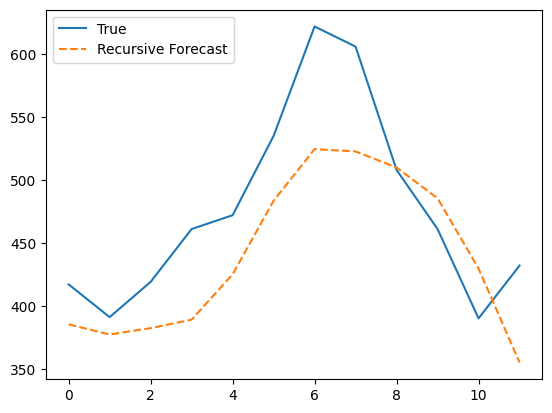

6
Model: lstm_dropout
Time steps: 2
Features: 1
Step: 2
RMSE Recursive: 51.952
Last window: [[[0.49938827]
  [0.31536337]
  [0.68341317]
  [0.56630641]
  [0.69177793]
  [1.29404123]
  [1.76246824]
  [1.87957499]
  [1.03473342]
  [0.65831886]
  [0.24844523]
  [0.47429396]
  [0.66668363]
  [0.5161178 ]
  [1.05146296]
  [0.96781528]
  [1.16856971]
  [1.60353765]
  [2.23926002]
  [2.33127247]
  [1.52825474]
  [1.05982773]
  [0.68341317]
  [1.04309819]]]


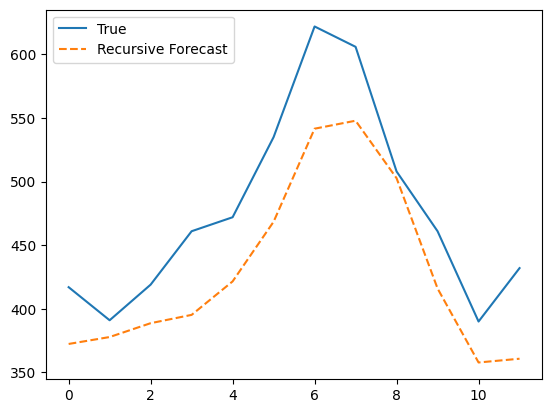

12
Model: lstm_dropout
Time steps: 4
Features: 1
Step: 4
RMSE Recursive: 66.421
Last window: [[[0.66668363]
  [0.5161178 ]
  [1.05146296]
  [0.96781528]
  [1.16856971]
  [1.60353765]
  [2.23926002]
  [2.33127247]
  [1.52825474]
  [1.05982773]
  [0.68341317]
  [1.04309819]]]


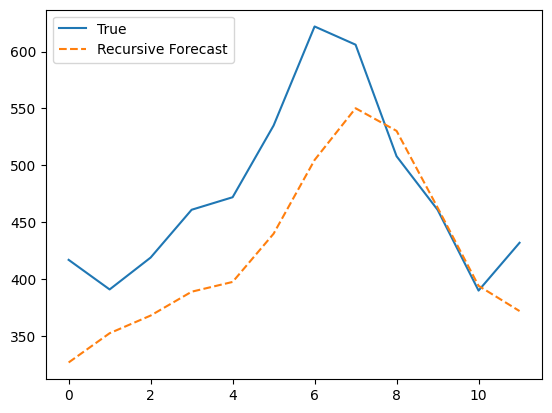

15
Model: lstm_dense
Time steps: 6
Features: 1
Step: 6
RMSE Recursive: 71.536
Last window: [[[0.66668363]
  [0.5161178 ]
  [1.05146296]
  [0.96781528]
  [1.16856971]
  [1.60353765]
  [2.23926002]
  [2.33127247]
  [1.52825474]
  [1.05982773]
  [0.68341317]
  [1.04309819]]]


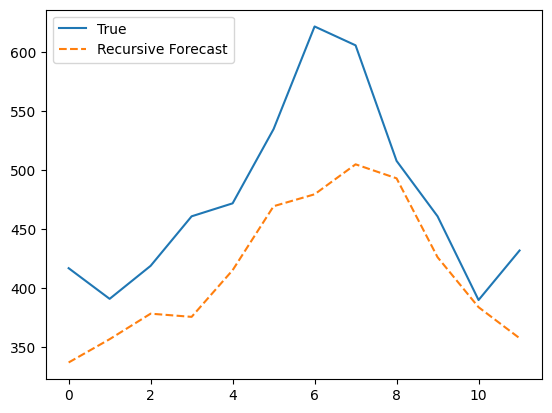

20
Model: lstm_dropout
Time steps: 12
Features: 1
Step: 12
RMSE Recursive: 56.583
Last window: [[[0.66668363]
  [0.5161178 ]
  [1.05146296]
  [0.96781528]
  [1.16856971]
  [1.60353765]
  [2.23926002]
  [2.33127247]
  [1.52825474]
  [1.05982773]
  [0.68341317]
  [1.04309819]]]


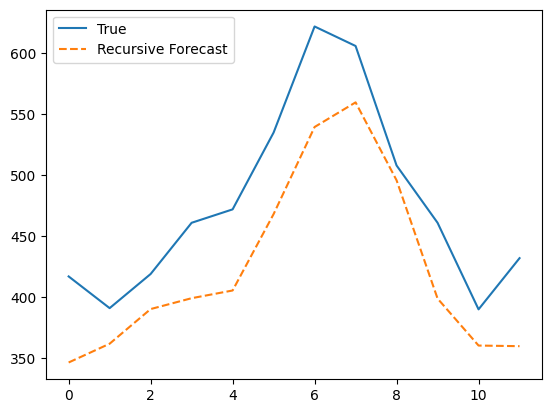

In [128]:
best_idx = df_results_steps.sort_values(by=["rmse_recursive"]).groupby("step")["rmse_recursive"].idxmin()

df_results_steps.loc[best_idx]

for i, param in df_results_steps.loc[best_idx].iterrows():
    model_func = globals()[param['model_name']]
    step = param['step']
    print(i)

    #preparing data with sequences
    X,y = create_sequences(df_scaled["#Passengers"], param['window_size'], steps=step)
    X = X.reshape((X.shape[0], X.shape[1], features))

    #splitting train and test to have last 12 months in the test set
    X_train = X[:-test_size]
    X_test= X[-test_size:]

    y_train = np.array(y[:-test_size])
    y_test = np.array(y[-test_size:])

    # come faccio a recuperare il riferimento alle funzioni dal model_name
    timesteps = step
    
    print(f"Model: {param['model_name']}")
    print(f"Time steps: {timesteps}")
    print(f"Features: {features}")
    print(f"Step: {step}")
    print(f"RMSE Recursive: {param['rmse_recursive']:.3f}")

    model= tf.keras.models.load_model(f"multisteps/models/model_v{i}.keras")

    # dopo il training

    # estraiamo le finestre per il test set corrette
    X_test = X[-test_size + step - 1:]
    y_test = y[-test_size + step - 1:]
    true_values = scaler.inverse_transform(
        df_scaled["#Passengers"].values[-test_size:].reshape(-1,1)
    ).flatten()
    
    last_window = X_test[:1]
    forecast_horizon = 12  # ultimi 12 mesi
    print(f"Last window: {last_window}")

    # Recursive forecast
    pred_recursive = recursive_forecast(model, last_window, step, forecast_horizon)
    pred_recursive = scaler.inverse_transform(pred_recursive.reshape(-1,1)).flatten()
    true_last12 = df["#Passengers"].values[-12:]
    plt.figure()
    plt.plot(true_last12, label="True")
    plt.plot(pred_recursive, linestyle="--", label="Recursive Forecast")
    plt.legend()
    plt.show()


    

Model: stacked_lstm
Time steps: 1
Features: 1
Step: 1
RMSE fan: 43.002


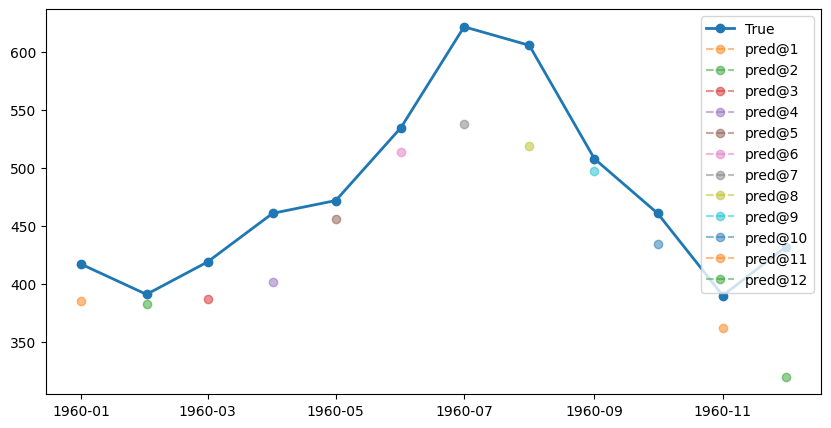

Model: lstm_dropout
Time steps: 2
Features: 1
Step: 2
RMSE fan: 36.595


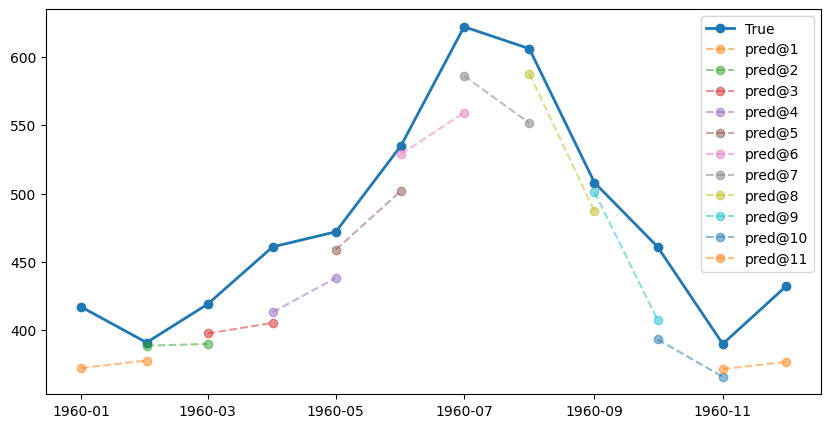

Model: lstm_dropout
Time steps: 4
Features: 1
Step: 4
RMSE fan: 67.993


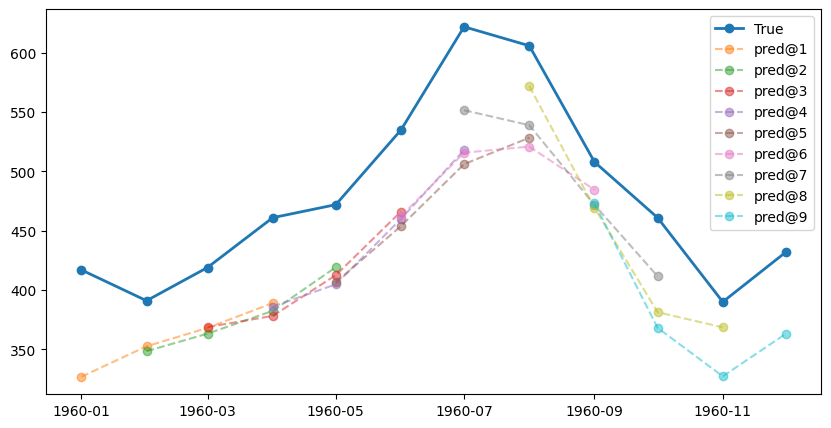

Model: lstm_dense
Time steps: 6
Features: 1
Step: 6
RMSE fan: 76.388


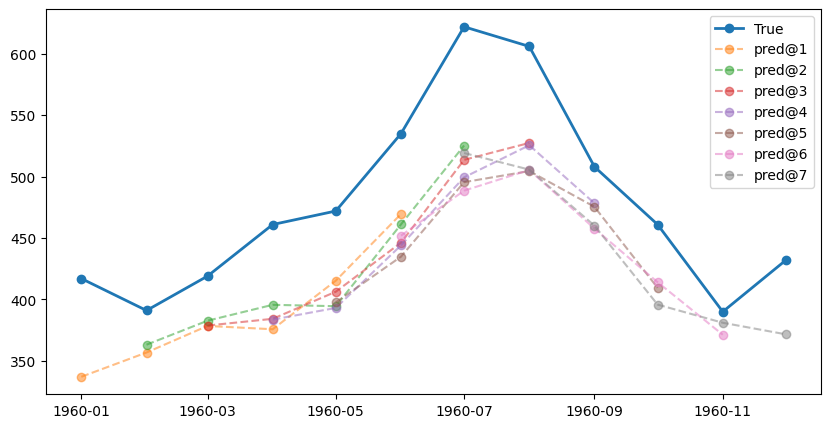

Model: lstm_dropout
Time steps: 12
Features: 1
Step: 12
RMSE fan: 56.583


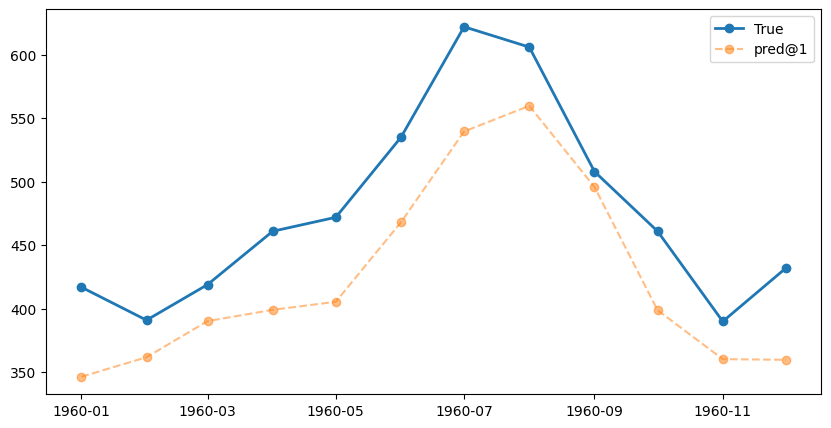

In [129]:
best_idx = df_results_steps.sort_values(by=["rmse_fan"]).groupby("step")["rmse_recursive"].idxmin()

for i, param in df_results_steps.loc[best_idx].iterrows():
    model_func = globals()[param['model_name']]
    step = param['step']

    #preparing data with sequences
    X,y = create_sequences(df_scaled["#Passengers"], param['window_size'], steps=step)
    X = X.reshape((X.shape[0], X.shape[1], features))

    #splitting train and test to have last 12 months in the test set
    X_train = X[:-test_size]
    X_test= X[-test_size:]

    y_train = np.array(y[:-test_size])
    y_test = np.array(y[-test_size:])

    # come faccio a recuperare il riferimento alle funzioni dal model_name
    timesteps = step
    
    print(f"Model: {param['model_name']}")
    print(f"Time steps: {timesteps}")
    print(f"Features: {features}")
    print(f"Step: {step}")
    print(f"RMSE fan: {param['rmse_fan']:.3f}")

    model= tf.keras.models.load_model(f"multisteps/models/model_v{i}.keras")

    # dopo il training

    # estraiamo le finestre per il test set corrette
    X_test = X[-test_size + step - 1:]
    y_test = y[-test_size + step - 1:]
    true_values = scaler.inverse_transform(
        df_scaled["#Passengers"].values[-test_size:].reshape(-1,1)
    ).flatten()
    
    # Sliding window / fan plot
    all_preds = sliding_window_forecast(model, X_test)

    # inverse transform di ogni predizione
    all_preds = [scaler.inverse_transform(pred.reshape(-1,1)).flatten() for pred in all_preds]

    plot_fan(df.index[-test_size:], true_values, all_preds)


    

,model_name,window_size,units,batch_size,learning_rate,dense_units,dropout_rate,best_val_loss,best_epoch,final_train_loss,epochs,time,step,rmse_recursive,rmse_fan
6,lstm_dropout,24,128,8,0.005,64.0,0.1,0.042772,33,0.013548,43,18.019343,2,51.951598,36.595302
4,stacked_lstm,12,128,4,0.010,NaN,NaN,0.041810,57,0.002477,67,26.478995,1,55.639835,43.001933
20,lstm_dropout,12,128,8,0.010,128.0,0.1,0.031326,63,0.012271,73,27.590587,12,56.582811,56.582812
12,lstm_dropout,12,128,8,0.010,128.0,0.1,0.045446,39,0.013143,49,31.772059,4,66.420509,67.992949
15,lstm_dense,12,128,4,0.010,64.0,NaN,0.039338,50,0.008432,60,22.940014,6,71.535762,76.388306


Best Model: lstm_dropout
Time steps: 2
Features: 1
Step: 2
RMSE Recursive: 51.952


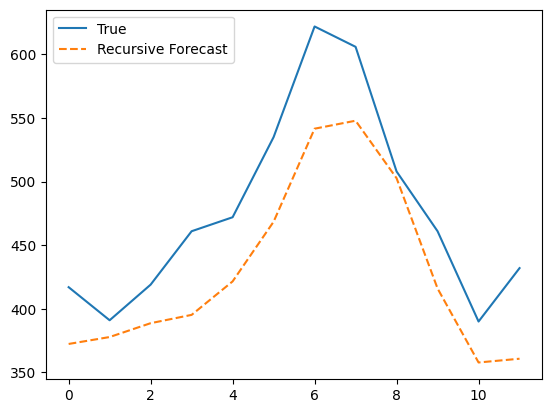

In [130]:
best_idx = df_results_steps.sort_values(by=["rmse_recursive"]).groupby("step")["rmse_recursive"].idxmin()

display(df_results_steps.loc[best_idx].sort_values(by=["rmse_recursive"]))

param = df_results_steps.loc[best_idx].sort_values(by=["rmse_recursive"]).iloc[0]
i= param.name
model = tf.keras.models.load_model(f"multisteps/models/model_v{best_idx.iloc[0]}.keras")
step = param['step']

#preparing data with sequences
X,y = create_sequences(df_scaled["#Passengers"], param['window_size'], steps=step)
X = X.reshape((X.shape[0], X.shape[1], features))

# come faccio a recuperare il riferimento alle funzioni dal model_name
timesteps = step

print(f"Best Model: {param['model_name']}")
print(f"Time steps: {timesteps}")
print(f"Features: {features}")
print(f"Step: {step}")
print(f"RMSE Recursive: {param['rmse_recursive']:.3f}")

model= tf.keras.models.load_model(f"multisteps/models/model_v{i}.keras")

forecast_horizon = 12  # ultimi 12 mesi

# estraiamo le finestre per il test set corrette
X_test = X[-forecast_horizon + step - 1:]
y_test = y[-forecast_horizon + step - 1:]
true_values = scaler.inverse_transform(
    df_scaled["#Passengers"].values[-test_size:].reshape(-1,1)
).flatten()

last_window = X_test[:1]
# print(f"Last window: {last_window}")

# Recursive forecast
pred_recursive = recursive_forecast(model, last_window, step, forecast_horizon)
pred_recursive = scaler.inverse_transform(pred_recursive.reshape(-1,1)).flatten()
true_last12 = df["#Passengers"].values[-12:]
plt.figure()
plt.plot(true_last12, label="True")
plt.plot(pred_recursive, linestyle="--", label="Recursive Forecast")
plt.legend()
plt.show()
